In [130]:
# Import all needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# 1. Load Data

In [131]:

#load loan dataset given in the loan.csv file
loan = pd.read_csv('loan.csv', low_memory=False)
print(loan.info())
loan.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB
None


id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  1077501    1296599       5000         5000           4975.0   36 months   
1  1077430    1314167       2500         2500           2500.0   60 months   
2  1077175    1313524       2400         2400           2400.0   36 months   
3  1076863    1277178      10000        10000          10000.0   36 months   
4  1075358    1311748       3000         3000           3000.0   60 months   

  int_rate  installment grade sub_grade  ... num_tl_90g_dpd_24m  \
0   10.65%       162.87     B        B2  ...                NaN   
1   15.27%        59.83     C        C4  ...                NaN   
2   15.96%        84.33     C        C5  ...                NaN   
3   13.49%       339.31     C        C1  ...                NaN   
4   12.69%        67.79     B        B5  ...                NaN   

  num_tl_op_past_12m pct_tl_nvr_dlq  percent_bc_gt_75 pub_rec_bankruptcies  \
0                NaN            NaN               NaN                  0.0   
1                NaN            NaN               NaN                  0.0   
2                NaN            NaN               NaN                  0.0   
3                NaN            NaN               NaN                  0.0   
4                NaN            NaN               NaN                  0.0   

  tax_liens tot_hi_cred_lim total_bal_ex_mort total_bc_limit  \
0       0.0             NaN               NaN            NaN   
1       0.0             NaN               NaN            NaN   
2       0.0             NaN               NaN            NaN   
3       0.0             NaN               NaN            NaN   
4       0.0             NaN               NaN            NaN   

  total_il_high_credit_limit  
0                        NaN  
1                        NaN  
2                        NaN  
3                        NaN  
4                        NaN  

[5 rows x 111 columns]

# 2. Inspecting Columns

### 2.1 Categorial Columns

In [132]:
#get categorical columns
categorical = loan.select_dtypes(include=['object'])
categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   term                 39717 non-null  object
 1   int_rate             39717 non-null  object
 2   grade                39717 non-null  object
 3   sub_grade            39717 non-null  object
 4   emp_title            37258 non-null  object
 5   emp_length           38642 non-null  object
 6   home_ownership       39717 non-null  object
 7   verification_status  39717 non-null  object
 8   issue_d              39717 non-null  object
 9   loan_status          39717 non-null  object
 10  pymnt_plan           39717 non-null  object
 11  url                  39717 non-null  object
 12  desc                 26775 non-null  object
 13  purpose              39717 non-null  object
 14  title                39706 non-null  object
 15  zip_code             39717 non-null  object
 16  addr

### 2.2 Numerical Columns

In [133]:
#get numerical columns
numerical = loan.select_dtypes(exclude=['object'])
numerical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 87 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              39717 non-null  int64  
 1   member_id                       39717 non-null  int64  
 2   loan_amnt                       39717 non-null  int64  
 3   funded_amnt                     39717 non-null  int64  
 4   funded_amnt_inv                 39717 non-null  float64
 5   installment                     39717 non-null  float64
 6   annual_inc                      39717 non-null  float64
 7   dti                             39717 non-null  float64
 8   delinq_2yrs                     39717 non-null  int64  
 9   inq_last_6mths                  39717 non-null  int64  
 10  mths_since_last_delinq          14035 non-null  float64
 11  mths_since_last_record          2786 non-null   float64
 12  open_acc                        

Looking at above results, it appears that some numerical, date type columns are present as object.

- int_rate, revol_util can be cleaned to remove "%" character and then convert it into float
- issue_d, earliest_cr_line, last_pymnt_d, next_pymnt_d, last_credit_pull_d sould be converted into date
- term should converted into number by removing "months" string literals from its value
- url column is not useful can be dropped
- drop member id and id columns since they are ids and has no business info

# 3. Data Cleaning

### 3.1 Clean Nulls

In [134]:
#check null values in dataset
loan.isna().sum()

id                                0
member_id                         0
loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   0
                              ...  
tax_liens                        39
tot_hi_cred_lim               39717
total_bal_ex_mort             39717
total_bc_limit                39717
total_il_high_credit_limit    39717
Length: 111, dtype: int64

In [135]:
# Drop columns having all values null
def removeColumnWithAllNullValue(dataframe):
    # List the column names which have all the values as null only
    nullValueColumnNames = dataframe.columns[(~dataframe.isnull()).sum() == 0]
    if len(nullValueColumnNames) == 0:
        print("No column found with all null value")
        return dataframe
    
    print(f"List of columns having all null values: \n {nullValueColumnNames}")
    # validate that these columns indeed have only null values.
    # Find count of columns among these columns which has any not null value. Assert that count of such column is zero
    assert ((~dataframe[nullValueColumnNames].isnull()).sum() > 0).sum() == 0, "Count of columns having all null values should be null."

    return dataframe.drop(nullValueColumnNames, axis=1)

# Drop empty rows
def removeRowsWithAllNullValue(dataframe):
    IsEmptyRowIndices = (~dataframe.isnull()).sum(axis=1) == 0
    emptyRowCount = IsEmptyRowIndices.sum()
    if (emptyRowCount == 0):
        print(f"No empty row found")
        return dataframe
    
    print(f"found {emptyRowCount} empty row(s)")  
    clearnedData = dataframe.drop(dataframe[IsEmptyRowIndices.index])
    assert ((~dataframe.isnull()).sum(axis=1) == 0).sum() == 0, "Count of rows with all values null should be zero"
    return clearnedData

# drop columns having single values
def dropMonotonousColumns(dataframe):
    singleValueColumns = dataframe.columns[dataframe.nunique() == 1]
    if (len(singleValueColumns) == 0):
        print("No column found having same value in all rows")
        return dataframe

    print(f"Columns with single value in all rows :{singleValueColumns}")
    return dataframe.drop(singleValueColumns, axis=1)

In [136]:
# in dataset, we can see around half of the columns are null, hence remove all columns having no values. Do the same for rows
loan = removeRowsWithAllNullValue(removeColumnWithAllNullValue(loan))

List of columns having all null values: 
 Index(['mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint',
       'verification_status_joint', 'tot_coll_amt', 'tot_cur_bal',
       'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m',
       'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m',
       'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi',
       'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
       'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m',
       'num_tl_30dpd', 'num_tl_90g_dpd_24m', '

### 3.2 Clean Rows

##### 3.2.1 Removing records with loan status as “Current”, as the loan is currently running and we can’t infer any information regarding default from such loans.

In [137]:
# drop rows having value of loan_status as Current
rowsWithLoanStatusAsCurrent = loan[loan.loan_status == "Current"]
print(f"dropping {rowsWithLoanStatusAsCurrent.shape[0]} rows having loan status = Current");

loan = loan.drop(rowsWithLoanStatusAsCurrent.index)
assert (loan.loan_status == "Current").sum() == 0, "Loan status should not have value Current"

# since we removed some rows, lets check and remove all null column and rows
loan = removeRowsWithAllNullValue(removeColumnWithAllNullValue(loan))

dropping 1140 rows having loan status = Current
List of columns having all null values: 
 Index(['next_pymnt_d'], dtype='object')
No empty row found


##### 3.2.2 dropping rows corresponding to very low count dimensions

In [138]:
# look through the purpose value counts
loan_purpose_values = loan["purpose"].value_counts()*100/loan.shape[0]

# remove rows with less than 1% of value counts in paricular purpose 
loan_purpose_delete = loan_purpose_values[loan_purpose_values<1].index.values
loan = loan[[False if p in loan_purpose_delete else True for p in loan["purpose"]]]

### 3.3 Drop monotonous columns

In [139]:
# drop monotonous values columns
loan = dropMonotonousColumns(loan)

# Since we removed some columns lets check for empty rows again.
loan = removeRowsWithAllNullValue(loan)

Columns with single value in all rows :Index(['pymnt_plan', 'initial_list_status', 'out_prncp', 'out_prncp_inv',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt',
       'tax_liens'],
      dtype='object')
No empty row found


### 3.4 Drop non behavioral columns

In [140]:
# drop id, member_id, url column since it does not seems to have any useful info
loan = loan.drop(['url', 'member_id', 'id'], axis=1)

### 3.5 Handle missing values

In [141]:
# check null values in emp_length
loan["emp_length"].isna().value_counts(normalize=True)

emp_length
False    0.973883
True     0.026117
Name: proportion, dtype: float64

In [142]:
columnNameHavingNull = "emp_length"
PercentageDropOverall = loan[columnNameHavingNull].isna().value_counts(normalize=True).filter(items=[True])[0]
chargedOffCount = loan["loan_status"].value_counts().filter(items=["Charged Off"]).iloc[0]
chargedOffCountHavingNullRevolUtil = loan[loan[columnNameHavingNull].isna()]["loan_status"].value_counts().filter(items=["Charged Off"]).iloc[0]
print(f"{round(PercentageDropOverall)}% overll and {round(100*chargedOffCountHavingNullRevolUtil/chargedOffCount)}% on ChargedOff records are impacted by null {columnNameHavingNull}")

0% overll and 4% on ChargedOff records are impacted by null emp_length


/var/folders/ws/t318bm0j4md5pdkww376lp5m0000gq/T/ipykernel_93786/2793191488.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  PercentageDropOverall = loan[columnNameHavingNull].isna().value_counts(normalize=True).filter(items=[True])[0]


In [143]:
columnNameHavingNull = "revol_util"
PercentageDropOverall = loan[columnNameHavingNull].isna().value_counts(normalize=True).filter(items=[True])[0]
chargedOffCount = loan["loan_status"].value_counts().filter(items=["Charged Off"]).iloc[0]
chargedOffCountHavingNullRevolUtil = loan[loan[columnNameHavingNull].isna()]["loan_status"].value_counts().filter(items=["Charged Off"]).iloc[0]
print(f"{round(PercentageDropOverall,2)}% overll and {round(100*chargedOffCountHavingNullRevolUtil/chargedOffCount,2)}% on ChargedOff records are impacted by null {columnNameHavingNull}")

0.0% overll and 0.29% on ChargedOff records are impacted by null revol_util


/var/folders/ws/t318bm0j4md5pdkww376lp5m0000gq/T/ipykernel_93786/2170988437.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  PercentageDropOverall = loan[columnNameHavingNull].isna().value_counts(normalize=True).filter(items=[True])[0]


In [144]:
# Based on above impact analysis we can take a call to drop these rows since impact is very low.

# In 12 unique values we have 10+ years the most for emp_length, but it is highly dependent variable so we will not impute but remove the rows with null values.
loan.dropna(axis=0, subset=["emp_length"], inplace=True)

# Revolving line utilization rate is used  to measure how much of the available revolving credit ( i.e lines of credit, credit cards etc.) a user is currently using.
# It is indication of user's credit usage relative to their total available credit. This is important for both the borrowers and lenders.
loan.dropna(axis=0, subset=["revol_util"], inplace=True)

### 3.6 Standardization

In [145]:
# update int_rate, revol_util without % sign and as numeric type
loan["int_rate"] = loan["int_rate"].apply(lambda x:x if pd.isna(x) else float(x.replace("%", "")))

loan["revol_util"] = loan["revol_util"].apply(lambda x:x if pd.isna(x) else float(x.replace('%', "")))

In [146]:
#get term data
loan["term"].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [147]:
# remove text data from term feature and store as numerical
loan["term"] = loan["term"].apply(lambda x:int(x.split()[0]))

In [148]:
# update emp_length feature with continuous values as int
# where (< 1 year) is assumed as 0 
# 10+ years is assumed as 10 
# rest are stored as their magnitude
loan["emp_length"] = pd.to_numeric(loan["emp_length"].apply(lambda x:x if pd.isna(x) else 0 if "<" in x else (x.split('+')[0] if "+" in x else x.split()[0])))

In [149]:
# convert issue_d into datetime
loan['issue_d'] = pd.to_datetime(loan['issue_d'], format='%b-%y')
loan['issue_d'].describe()

count                            36388
mean     2010-10-26 01:35:46.070132992
min                2007-06-01 00:00:00
25%                2010-05-01 00:00:00
50%                2011-01-01 00:00:00
75%                2011-08-01 00:00:00
max                2011-12-01 00:00:00
Name: issue_d, dtype: object

In [150]:
# convert earliest_cr_line into datetime [special handling since year is in 2 digits and start from 1946, default parsing makes it 2046 instead of 1946.]
loan["earliest_cr_line"] = loan["earliest_cr_line"].apply(lambda x:x.split("-")[0] + "-" + ("19" if int(x.split("-")[1]) > 45 else "20") + x.split("-")[1])
loan['earliest_cr_line'] = pd.to_datetime(loan["earliest_cr_line"], format='%b-%Y')
loan['earliest_cr_line'].describe()

count                            36388
mean     1997-03-20 18:19:42.455754624
min                1946-01-01 00:00:00
25%                1994-01-01 00:00:00
50%                1998-06-01 00:00:00
75%                2001-09-01 00:00:00
max                2008-11-01 00:00:00
Name: earliest_cr_line, dtype: object

In [151]:
# convert last_pymnt_d into datetime
loan['last_pymnt_d'] = pd.to_datetime(loan['last_pymnt_d'], format='%b-%y')
loan['last_pymnt_d'].describe()

count                            36331
mean     2013-03-10 03:35:03.757122048
min                2008-01-01 00:00:00
25%                2012-04-01 00:00:00
50%                2013-04-01 00:00:00
75%                2014-04-01 00:00:00
max                2016-05-01 00:00:00
Name: last_pymnt_d, dtype: object

In [152]:
# convert last_credit_pull_d into datetime
loan['last_credit_pull_d'] = pd.to_datetime(loan['last_credit_pull_d'], format='%b-%y')
loan['last_credit_pull_d'].describe()

count                            36386
mean     2014-08-26 05:32:40.380366336
min                2007-06-01 00:00:00
25%                2013-05-01 00:00:00
50%                2015-02-01 00:00:00
75%                2016-04-01 00:00:00
max                2016-05-01 00:00:00
Name: last_credit_pull_d, dtype: object

### 3.7 Outlier Treatment

In [153]:
def dropHigherQuantileRecords(loan, columnName, quantileCutValue):
    annual_inc_q = loan[columnName].quantile(quantileCutValue)
    filterResult = loan[columnName] < annual_inc_q
    chargedOffCount = loan["loan_status"][~filterResult].value_counts().filter(items=["Charged Off"])[0]
    print(f"{filterResult.value_counts().filter(items=[False])[0]} rows removed of which {chargedOffCount} belongs to Charged off")
    loan = loan[filterResult]

In [154]:
#describe borrower annual income
loan["annual_inc"].describe()

count    3.638800e+04
mean     6.954019e+04
std      6.495376e+04
min      4.080000e+03
25%      4.149600e+04
50%      6.000000e+04
75%      8.300000e+04
max      6.000000e+06
Name: annual_inc, dtype: float64

In [155]:
# for annual_inc, the highest value is 6000000 where 75% quantile value is 83000, and is 100 times the mean
# we need to remomve outliers from annual_inc i.e. 99 to 100%
dropHigherQuantileRecords(loan, "annual_inc", 0.99)

364 rows removed of which 40 belongs to Charged off


/var/folders/ws/t318bm0j4md5pdkww376lp5m0000gq/T/ipykernel_93786/462689564.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  chargedOffCount = loan["loan_status"][~filterResult].value_counts().filter(items=["Charged Off"])[0]
/var/folders/ws/t318bm0j4md5pdkww376lp5m0000gq/T/ipykernel_93786/462689564.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"{filterResult.value_counts().filter(items=[False])[0]} rows removed of which {chargedOffCount} belongs to Charged off")


In [156]:
#describe borrower's number of open credit lines in the borrower's credit file
loan["open_acc"].describe()

count    36388.000000
mean         9.323513
std          4.387256
min          2.000000
25%          6.000000
50%          9.000000
75%         12.000000
max         44.000000
Name: open_acc, dtype: float64

In [157]:
# for open_acc, the highest value is 44 where 75% quantile value is 12, and is 5 times the mean
# we need to remomve outliers from open_acc i.e. 99.9 to 100%
dropHigherQuantileRecords(loan, "open_acc", 0.999)

41 rows removed of which 11 belongs to Charged off


/var/folders/ws/t318bm0j4md5pdkww376lp5m0000gq/T/ipykernel_93786/462689564.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  chargedOffCount = loan["loan_status"][~filterResult].value_counts().filter(items=["Charged Off"])[0]
/var/folders/ws/t318bm0j4md5pdkww376lp5m0000gq/T/ipykernel_93786/462689564.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"{filterResult.value_counts().filter(items=[False])[0]} rows removed of which {chargedOffCount} belongs to Charged off")


In [158]:
#describe borrower's total number of credit lines currently in the borrower's credit file
loan["total_acc"].describe()

count    36388.000000
mean        22.146367
std         11.399378
min          2.000000
25%         14.000000
50%         20.000000
75%         29.000000
max         90.000000
Name: total_acc, dtype: float64

In [159]:
# for total_acc, the highest value is 90 where 75% quantile value is 29, and is 4 times the mean
# we need to remomve outliers from total_acc i.e. 98 to 100%
dropHigherQuantileRecords(loan, "total_acc", 0.98)


732 rows removed of which 88 belongs to Charged off


/var/folders/ws/t318bm0j4md5pdkww376lp5m0000gq/T/ipykernel_93786/462689564.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  chargedOffCount = loan["loan_status"][~filterResult].value_counts().filter(items=["Charged Off"])[0]
/var/folders/ws/t318bm0j4md5pdkww376lp5m0000gq/T/ipykernel_93786/462689564.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"{filterResult.value_counts().filter(items=[False])[0]} rows removed of which {chargedOffCount} belongs to Charged off")


# 4. Derive Variables

### 4.1 Month and Year extraction from Date

We can derive year and month from date type columns which can be used in analysis.
We can also represent loan_status column into is_defaulter indicating if the loan was defaulted or not.

In [160]:
# extracting month and year from issue_date
loan['issue_d_month'] = loan['issue_d'].apply(lambda x: x.month)
loan['issue_d_year'] = loan['issue_d'].apply(lambda x: x.year)

# get year from issue_d and replace the same
loan["earliest_cr_line_month"] = loan["earliest_cr_line"].apply(lambda x: x.month)
loan["earliest_cr_line_year"] = loan["earliest_cr_line"].apply(lambda x: x.year)

# Create new column as representation of update loan_status as Fully Paid to 0 and Charged Off to 1
loan["is_defaulter"] = loan["loan_status"].apply(lambda x: False if x == "Fully Paid" else True)


### 4.2 Binning Continuous data

In [161]:
# describe loan amount
loan["loan_amnt"].describe()

count    36388.000000
mean     11206.591459
std       7352.059523
min        500.000000
25%       5575.000000
50%      10000.000000
75%      15000.000000
max      35000.000000
Name: loan_amnt, dtype: float64

In [162]:
# create bins for loan_amnt range
bins = [0, 5000, 10000, 15000, 20000, 25000, 36000]
bucket_l = ['0-5000', '5000-10000', '10000-15000', '15000-20000', '20000-25000','25000+']
loan['loan_amnt_range'] = pd.cut(loan['loan_amnt'], bins, labels=bucket_l)

In [163]:
# describe interest rate
loan["int_rate"].describe()

count    36388.000000
mean        11.969693
std          3.687174
min          5.420000
25%          8.940000
50%         11.830000
75%         14.420000
max         24.110000
Name: int_rate, dtype: float64

In [164]:
# create bins for int_rate range
bins = [0, 7.5, 10, 12.5, 15, 100]
bucket_l = ['0-7.5', '7.5-10', '10-12.5', '12.5-15', '15+']
loan['int_rate_range'] = pd.cut(loan['int_rate'], bins, labels=bucket_l)
loan[['int_rate_range', 'int_rate']].head(10)

int_rate_range  int_rate
0         10-12.5     10.65
1             15+     15.27
2             15+     15.96
3         12.5-15     13.49
5          7.5-10      7.90
6             15+     15.96
7             15+     18.64
8             15+     21.28
9         12.5-15     12.69
10        12.5-15     14.65

In [165]:
loan['annual_inc'].describe()

count    3.638800e+04
mean     6.954019e+04
std      6.495376e+04
min      4.080000e+03
25%      4.149600e+04
50%      6.000000e+04
75%      8.300000e+04
max      6.000000e+06
Name: annual_inc, dtype: float64

In [166]:
# create bins for annual_inc range
bins = [0, 25000, 50000, 75000, 100000, 1000000]
bucket_l = ['0-25000', '25000-50000', '50000-75000', '75000-100000', '100000+']
loan['annual_inc_range'] = pd.cut(loan['annual_inc'], bins, labels=bucket_l)

In [167]:
loan['revol_util'].describe()

count    36388.000000
mean        49.141574
std         28.242785
min          0.000000
25%         25.900000
50%         49.600000
75%         72.600000
max         99.900000
Name: revol_util, dtype: float64

In [168]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
bin_labels = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
loan['revol_util_range'] = pd.cut(loan['revol_util'], bins, labels=bin_labels)
loan[['revol_util_range', 'revol_util']].head(10)

revol_util_range  revol_util
0                80        83.7
1                 0         9.4
2                90        98.5
3                20        21.0
5                20        28.3
6                80        85.6
7                80        87.5
8                30        32.6
9                30        36.5
10               20        20.6

In [169]:
loan['installment'].describe()

count    36388.000000
mean       327.010464
std        208.795642
min         15.690000
25%        169.010000
50%        282.950000
75%        432.260000
max       1305.190000
Name: installment, dtype: float64

In [170]:
# create bins for installment range
bins = [0, 200, 500, 800, 1500]
bins_label = ['low', 'medium', 'high', 'very high']
loan['installment_range'] = pd.cut(loan['installment'], bins, labels=bins_label)
loan[['installment_range', 'installment']].head(10)

installment_range  installment
0                low       162.87
1                low        59.83
2                low        84.33
3             medium       339.31
5                low       156.46
6                low       170.08
7                low       109.43
8                low       152.39
9                low       121.45
10               low       153.45

In [171]:
loan['dti'].describe()

count    36388.000000
mean        13.346417
std          6.644824
min          0.000000
25%          8.230000
50%         13.445000
75%         18.600000
max         29.990000
Name: dti, dtype: float64

In [172]:
# create bins for dti range
bins = [-1, 5.00, 10.00, 15.00, 20.00, 25.00, 50.00]
bucket_l = ['0-5%', '5-10%', '10-15%', '15-20%', '20-25%', '25%+']
loan['dti_range'] = pd.cut(loan['dti'], bins, labels=bucket_l)
loan[['dti_range','dti']].head(10)

dti_range    dti
0       25%+  27.65
1       0-5%   1.00
2      5-10%   8.72
3     15-20%  20.00
5     10-15%  11.20
6     20-25%  23.51
7      5-10%   5.35
8      5-10%   5.55
9     15-20%  18.08
10    15-20%  16.12

# 5. Univariate Analysis

In [173]:
# find current loan status ie. count of Current, Paid and Charged Off (defaulters). 
# Current are likely to be defaulters
loan["loan_status"].value_counts(normalize=True)

loan_status
Fully Paid     0.856958
Charged Off    0.143042
Name: proportion, dtype: float64

<Axes: xlabel='loan_status', ylabel='count'>

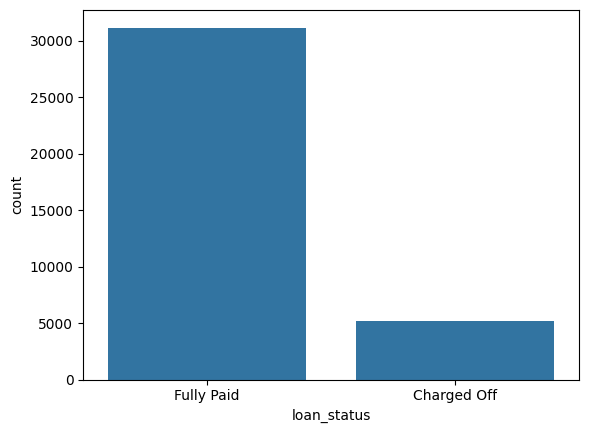

In [174]:
# check for amount of defaults in the data using countplot
sns.countplot(loan, x="loan_status")

From above plot we can see that ~14% of loans are defaulted.

<Axes: xlabel='annual_inc_range', ylabel='count'>

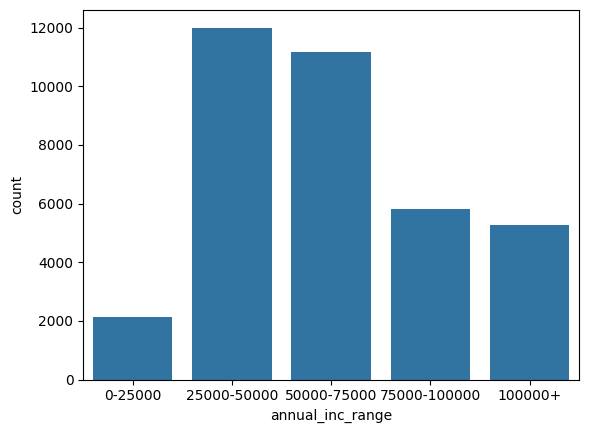

In [175]:
sns.countplot(loan, x="annual_inc_range")

<Axes: xlabel='issue_d_month', ylabel='count'>

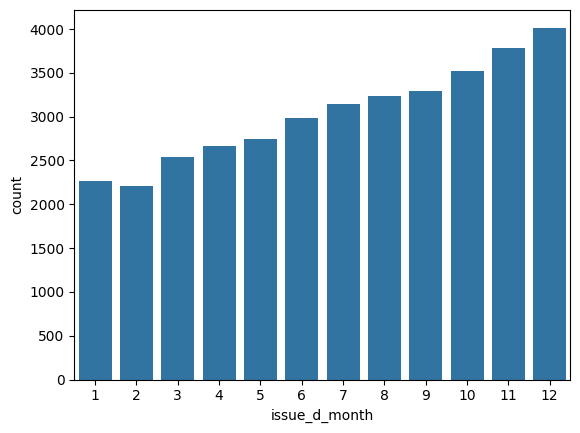

In [176]:
sns.countplot(loan, x="issue_d_month")

<Axes: xlabel='issue_d_year', ylabel='count'>

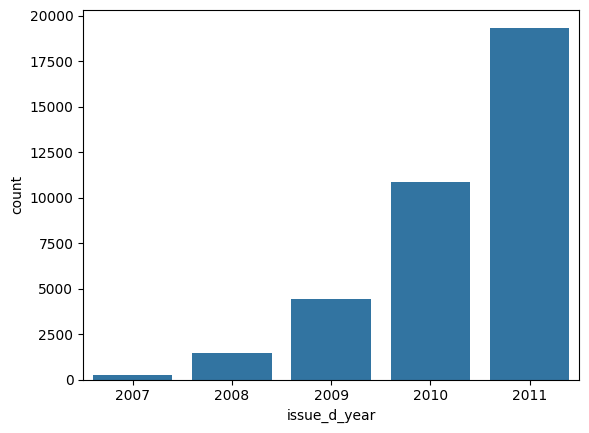

In [177]:
sns.countplot(loan, x="issue_d_year")

<Axes: xlabel='int_rate_range', ylabel='count'>

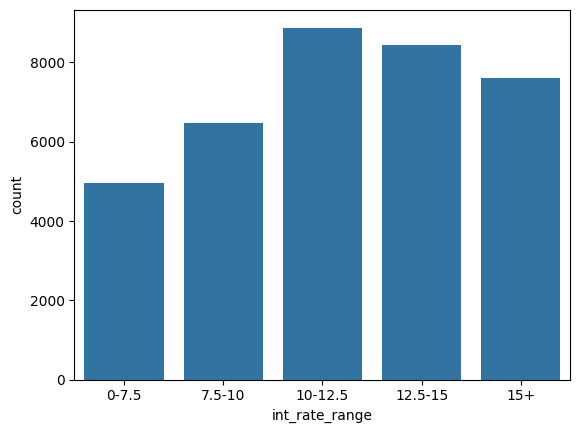

In [178]:
sns.countplot(loan, x="int_rate_range")

<Axes: xlabel='revol_util_range', ylabel='count'>

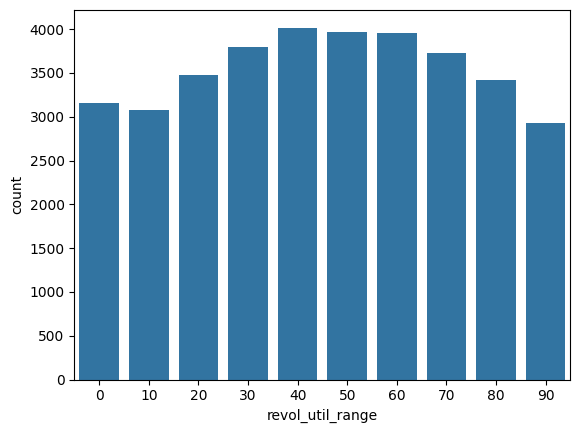

In [179]:
sns.countplot(loan, x="revol_util_range")

<Axes: xlabel='addr_state', ylabel='count'>

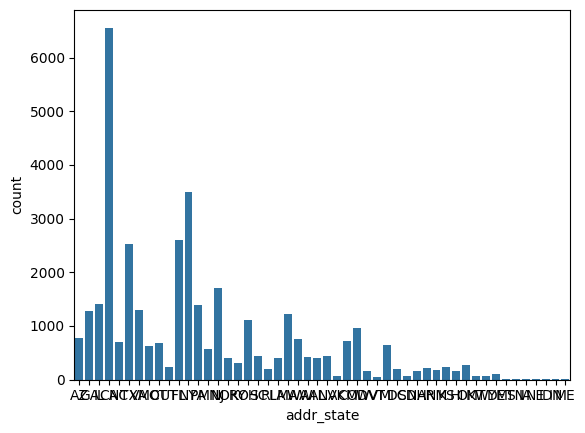

In [180]:
sns.countplot(loan, x="addr_state")

<Axes: xlabel='delinq_2yrs', ylabel='count'>

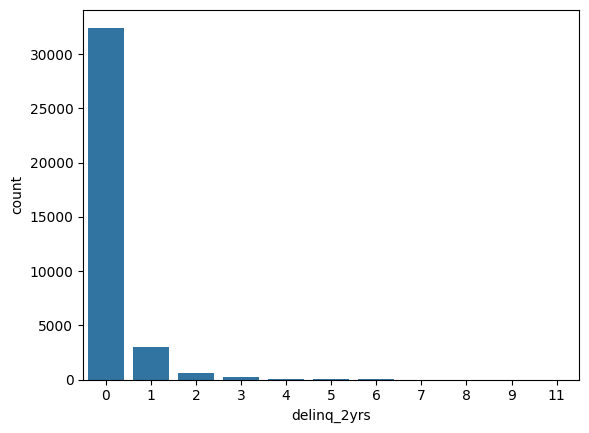

In [181]:
sns.countplot(loan, x="delinq_2yrs")


<Axes: xlabel='emp_length', ylabel='count'>

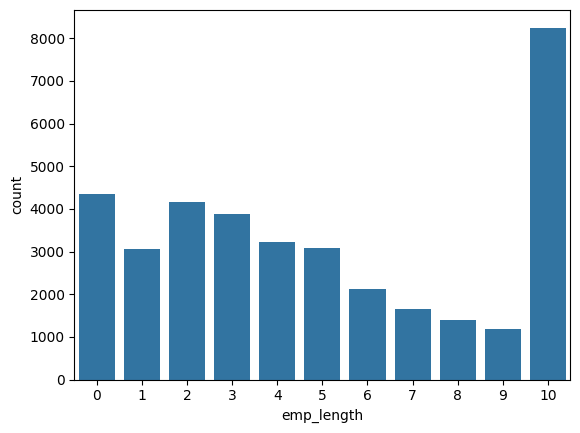

In [182]:
sns.countplot(loan, x="emp_length")


<Axes: xlabel='grade', ylabel='count'>

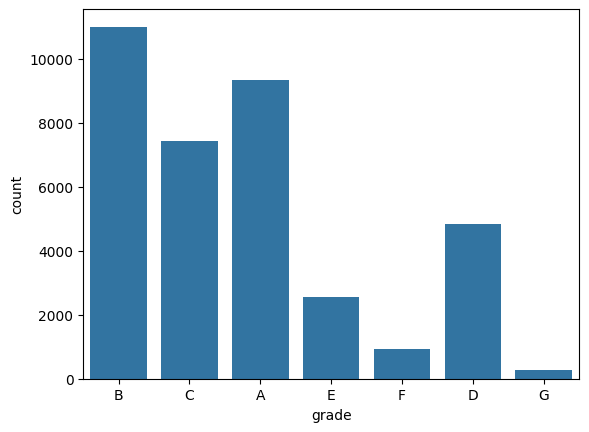

In [183]:
sns.countplot(loan, x="grade")

<Axes: xlabel='home_ownership', ylabel='count'>

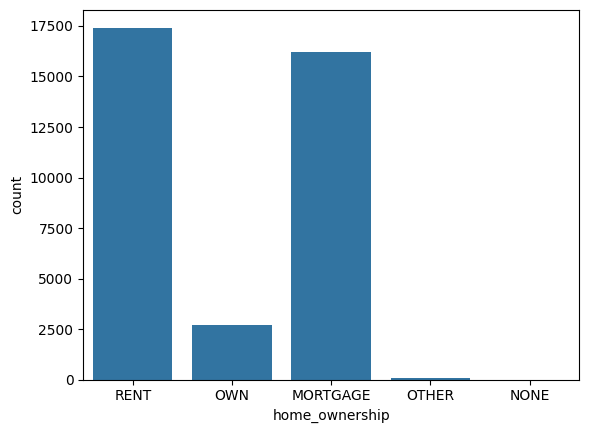

In [184]:
sns.countplot(loan, x="home_ownership")


<Axes: xlabel='total_acc', ylabel='count'>

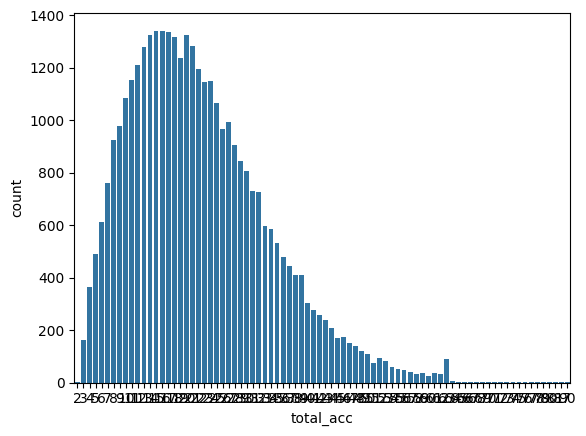

In [185]:
sns.countplot(loan, x="total_acc")

<Axes: xlabel='verification_status', ylabel='count'>

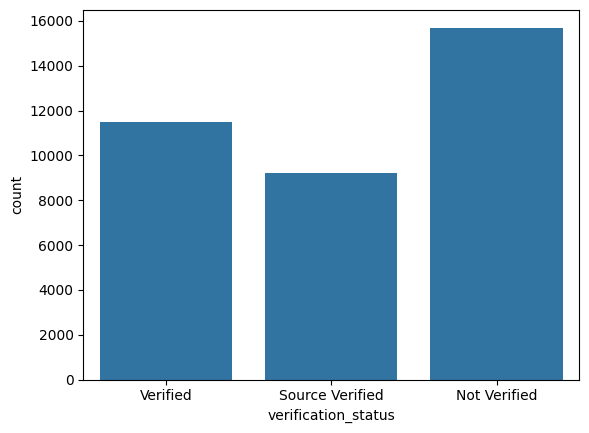

In [186]:
sns.countplot(loan, x="verification_status")

<Axes: xlabel='open_acc', ylabel='count'>

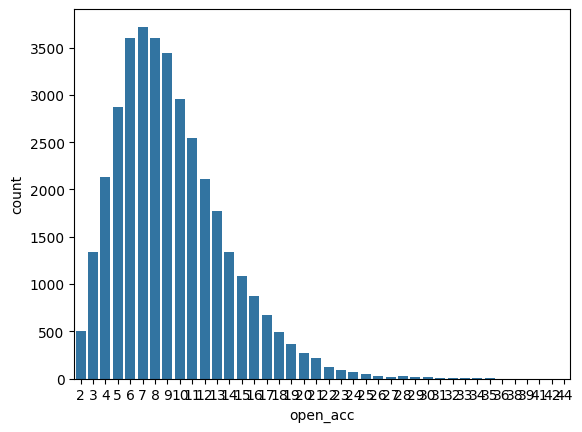

In [187]:
sns.countplot(loan, x="open_acc")

<Axes: xlabel='term', ylabel='count'>

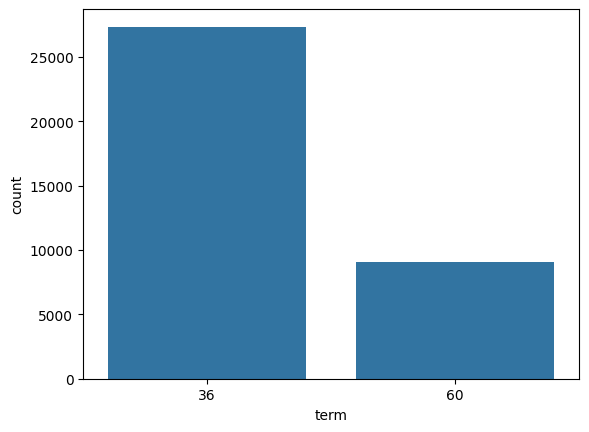

In [188]:
sns.countplot(loan, x="term")

<Axes: xlabel='purpose', ylabel='count'>

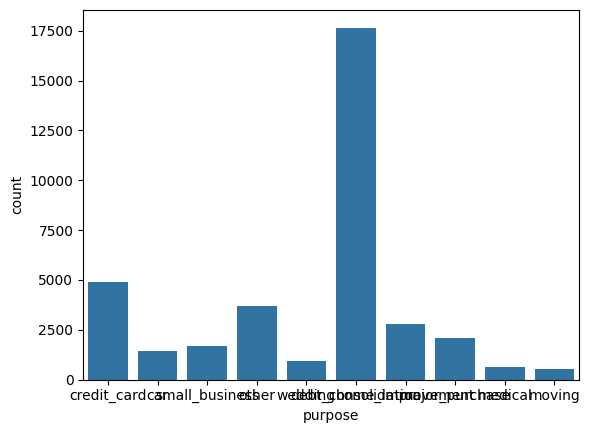

In [189]:
sns.countplot(loan, x="purpose")

# 6. Segmented Univariate Analysis

In [190]:
def plotUnivariateRatioBarSegmentedByDefaulter(feature, data=loan, rsorted=True):
    plt.figure(figsize=(20,10))
    feature_dimension = data[feature].unique()
    if rsorted:
        feature_dimension = data[feature].value_counts().index.array
    else:
        feature_dimension = data[feature].unique()
    totalCount = []
    for fd in feature_dimension:
        feature_filter = data[data[feature]==fd]
        # calculate features count in feature filter for defaulters
        defaulterCount = len(feature_filter[feature_filter["loan_status"]=="Charged Off"])
        totalCount.append(defaulterCount*100/feature_filter["loan_status"].count())
    df = pd.DataFrame({"feature_dimension": feature_dimension, "totalCount": totalCount}).sort_values(by=["totalCount"])
    plt.bar(df.feature_dimension, df.totalCount, color='orange', edgecolor='white')
    plt.title("Loan Defaults wrt "+str(feature)+" feature - countplot")
    plt.xlabel(feature, fontsize=16)
    plt.ylabel("defaulter %", fontsize=16)
    plt.show()

# function to plot univariate with default status scale 0 - 1
def plotUnivariateBarSegmentedByDefaulter(x):
    plt.figure(figsize=(20,10))
    #plot bar graph against feature on x-axis and loan status on y-axis
    sns.barplot(x=x, y='is_defaulter', data=loan)
    plt.title("Loan Defaults wrt "+str(x)+" - countplot")
    plt.xlabel(x, fontsize=16)
    plt.ylabel("defaulter ratio", fontsize=16)
    plt.show()

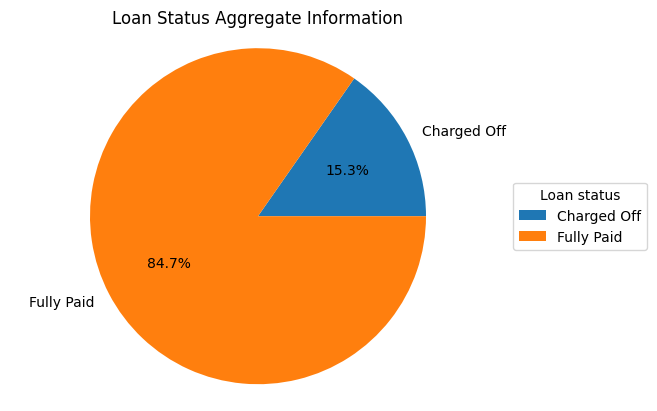

In [191]:
# plotting pie chart for different types of loan status
loan_status_grouped_data = loan.groupby(['loan_status'])['funded_amnt_inv'].sum().reset_index()

plt.figure()
plt.pie(loan_status_grouped_data["funded_amnt_inv"],labels=loan_status_grouped_data["loan_status"],autopct='%1.1f%%')
plt.title('Loan Status Aggregate Information')
plt.axis('equal')
plt.legend(title="Loan status",loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

In [192]:
loan["purpose"].value_counts()

purpose
debt_consolidation    17664
credit_card            4897
other                  3700
home_improvement       2782
major_purchase         2074
small_business         1709
car                    1446
wedding                 912
medical                 654
moving                  550
Name: count, dtype: int64

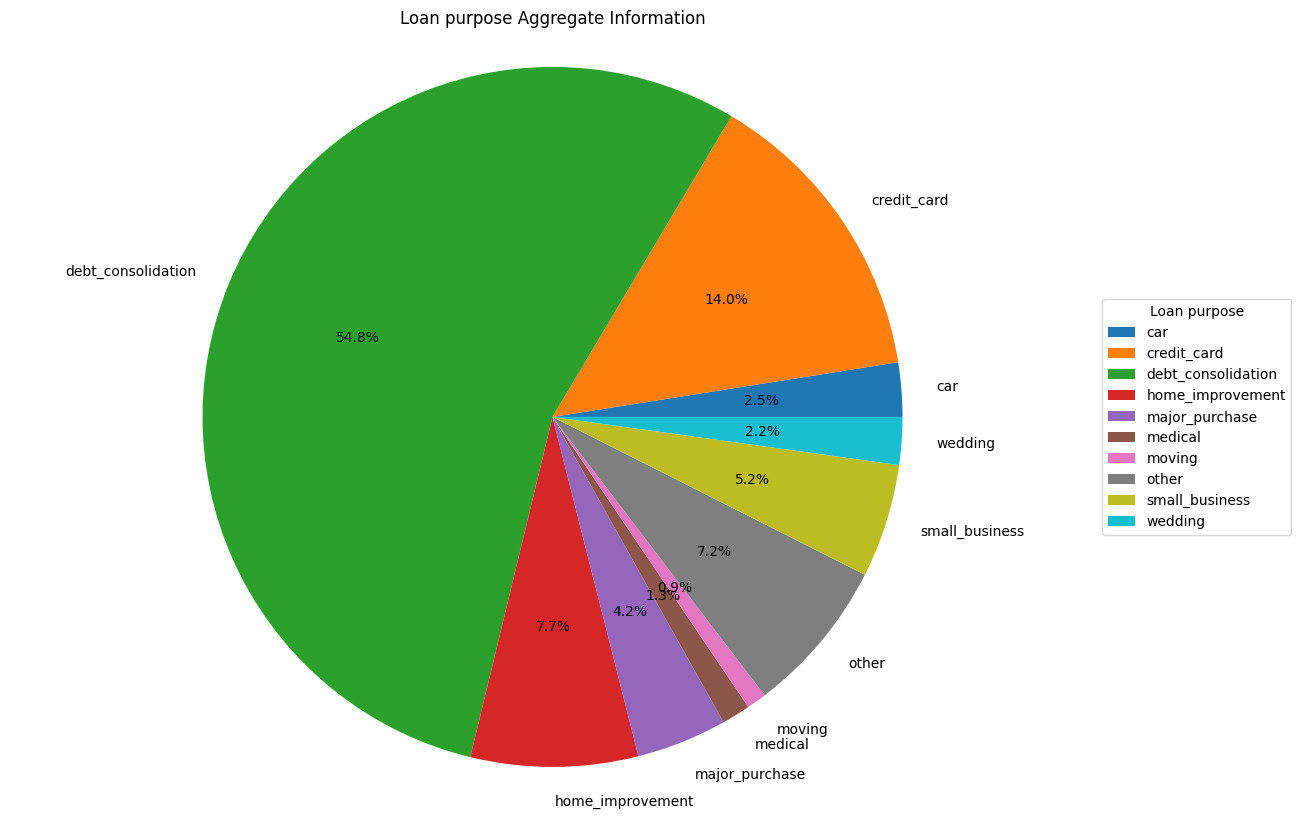

In [193]:
# plotting pie chart for different types of purpose
loans_purpose_grouped_data = loan.groupby(['purpose'])['funded_amnt_inv'].sum().reset_index()

plt.figure(figsize=(14, 10))
plt.pie(loans_purpose_grouped_data["funded_amnt_inv"],labels=loans_purpose_grouped_data["purpose"],autopct='%1.1f%%')
plt.title('Loan purpose Aggregate Information')
plt.axis('equal')
plt.legend(title="Loan purpose",loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

### 6.1 Categorical Columns

In [194]:
#get term values
loan["term"].value_counts()

term
36    27330
60     9058
Name: count, dtype: int64

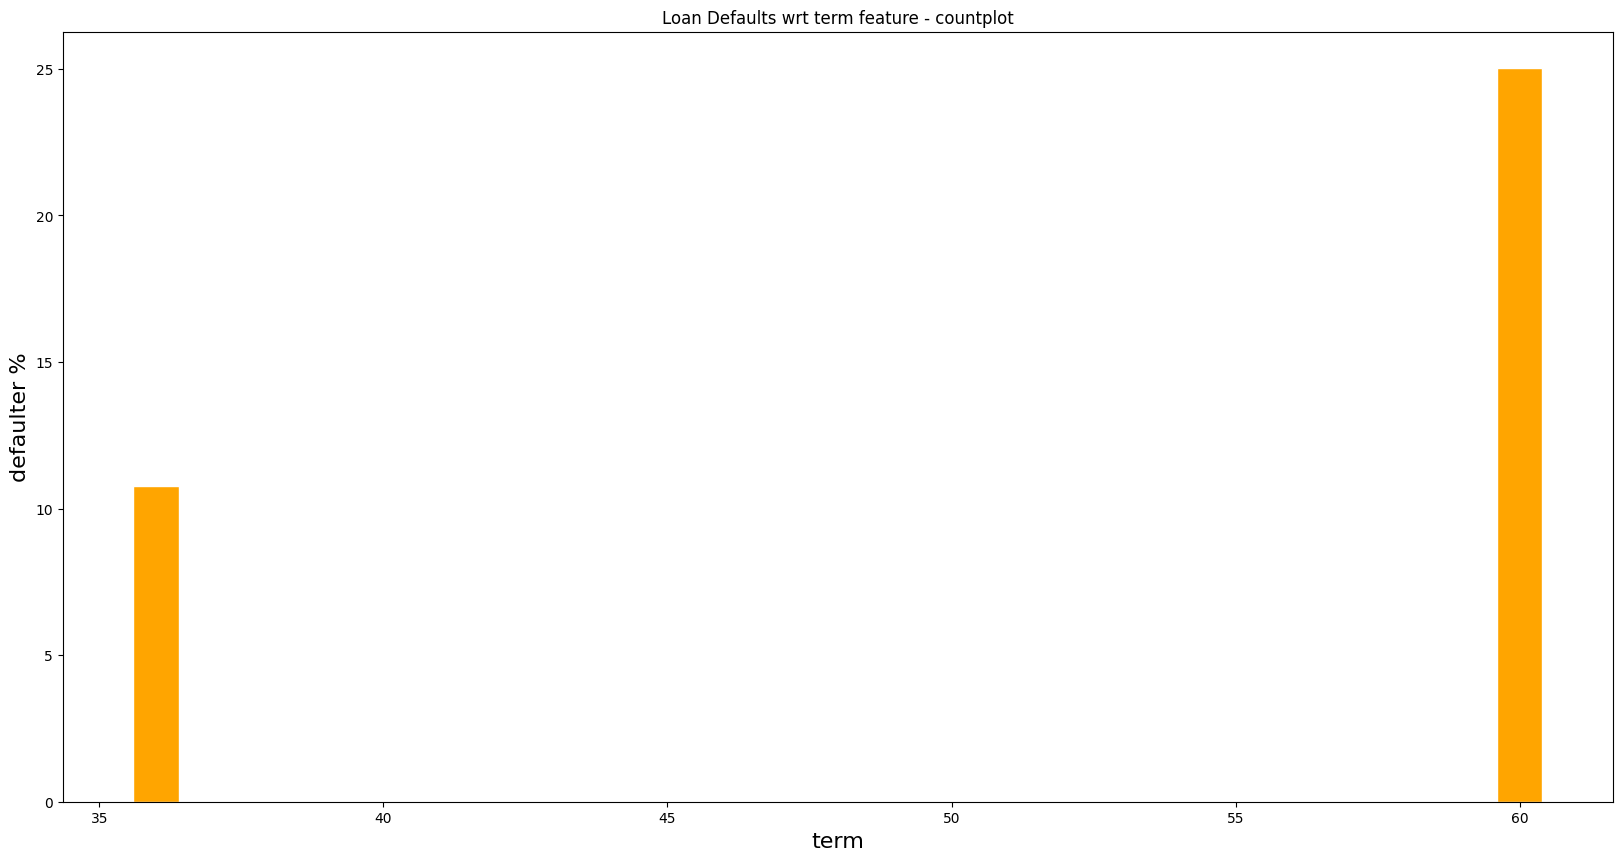

In [195]:
# check for defaulters wrt term in the data using countplot
plotUnivariateRatioBarSegmentedByDefaulter("term")

From above plot for `term` we can infer that the defaulters rate is increasing wrt term ie. The number of payments on the loan, hence the chances of loan getting deaulted is less for 36m than 60m.

so `term` can become a deciding variable for loan approval.

In [196]:
#get grade values
loan["grade"].value_counts()

grade
B    11013
A     9340
C     7429
D     4846
E     2542
F      931
G      287
Name: count, dtype: int64

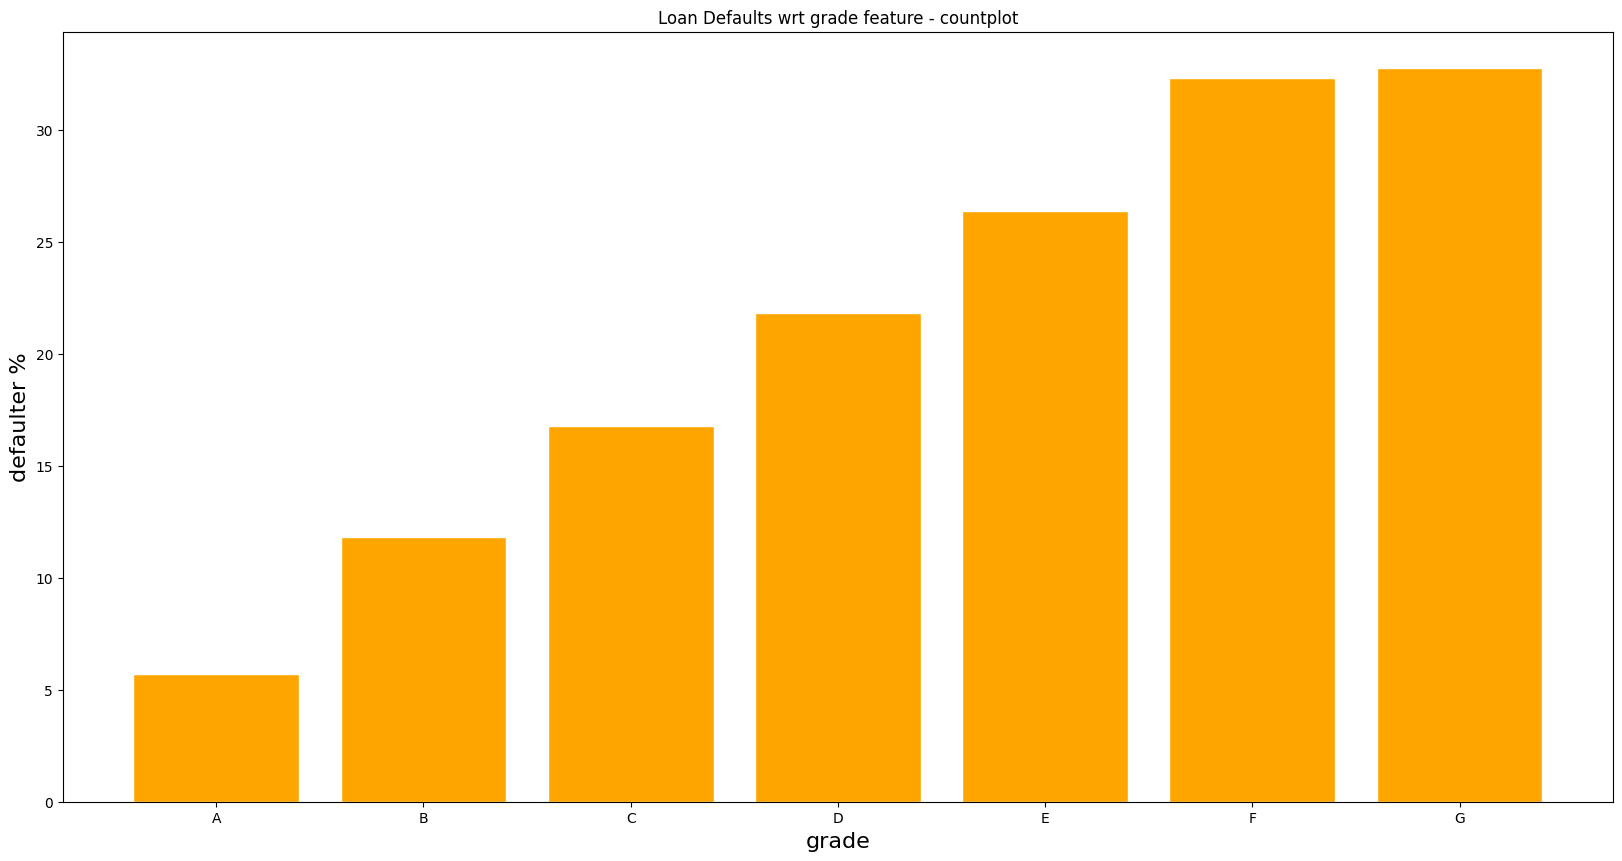

In [197]:
# check for defaulters wrt grade in the data using countplot
plotUnivariateRatioBarSegmentedByDefaulter("grade")

From above plot for `grade` we can infer that the defaulters rate is increasing wrt grade, hence the chances of loan getting deaulted increases with the grade from A moving towards G.

so `grade` can become a deciding variable for loan approval.

In [198]:
#get sub_grade values
loan["sub_grade"].value_counts()

sub_grade
A4    2695
B3    2661
A5    2546
B5    2487
B4    2312
C1    1955
B2    1890
C2    1824
A3    1688
B1    1663
C3    1415
A2    1395
D2    1223
C4    1148
C5    1087
D3    1058
A1    1016
D1     890
D4     878
D5     797
E1     697
E2     579
E3     488
E4     406
E5     372
F1     292
F2     220
F3     166
F4     145
F5     108
G1      91
G2      73
G4      50
G3      45
G5      28
Name: count, dtype: int64

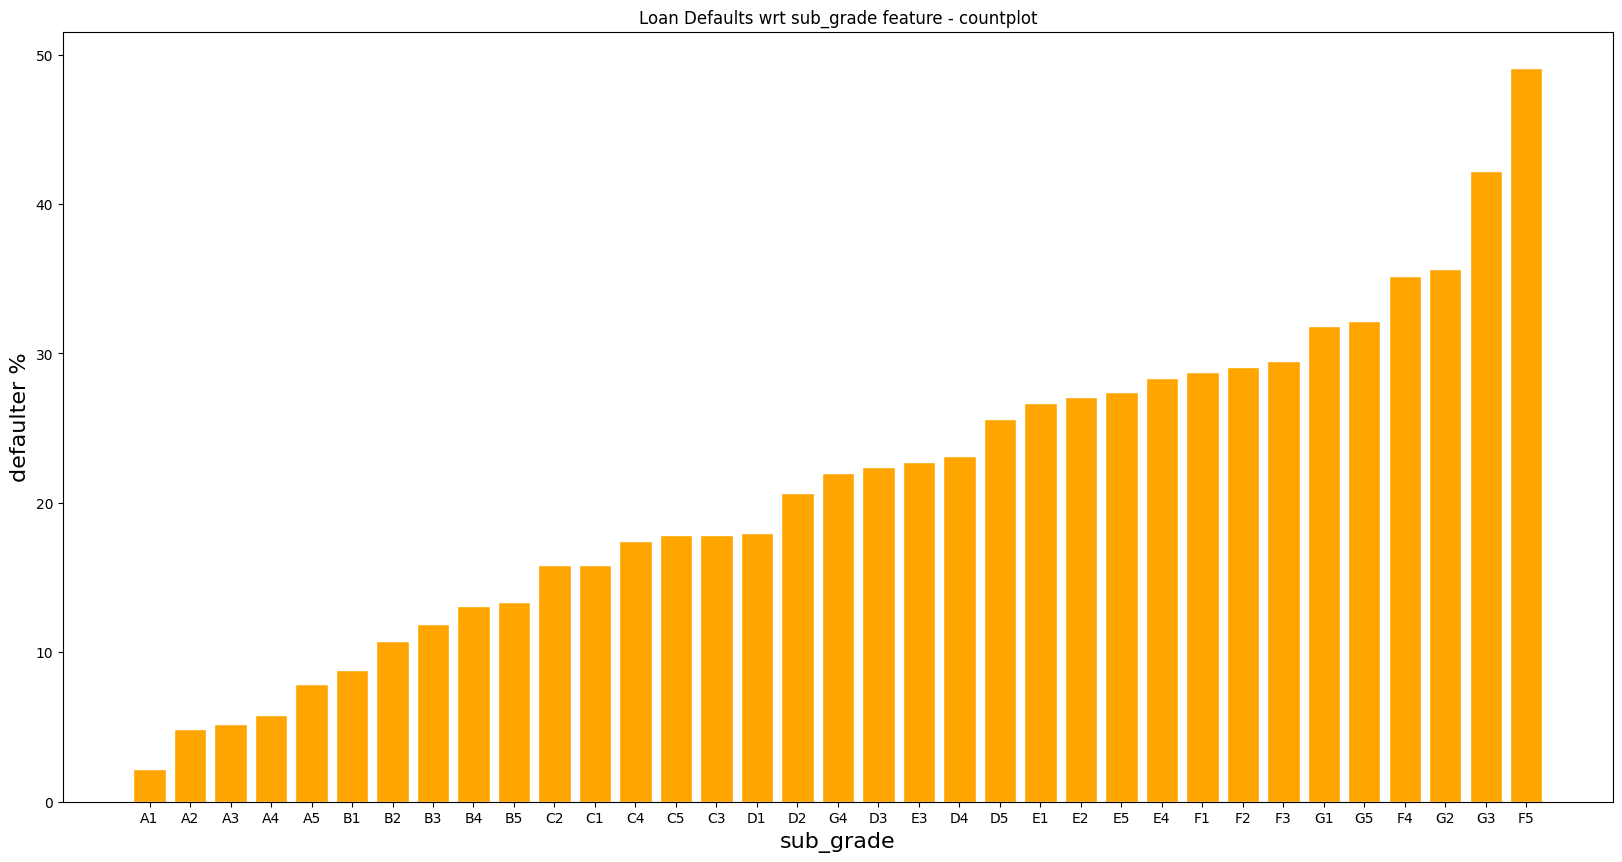

In [199]:
# check for defaulters wrt sub_grade in the data using countplot
plotUnivariateRatioBarSegmentedByDefaulter("sub_grade")

From above plot for `sub_grade` we can infer that the defaulters rate is increasing wrt `sub_grade`, hence the chances of loan getting deaulted increases with the `sub_grade` from A1 moving towards G5.

so `‘sub_grade’` can become a deciding variable for loan approval.

In [200]:
#get home_ownership values
loan["home_ownership"].value_counts()

home_ownership
RENT        17420
MORTGAGE    16191
OWN          2683
OTHER          91
NONE            3
Name: count, dtype: int64

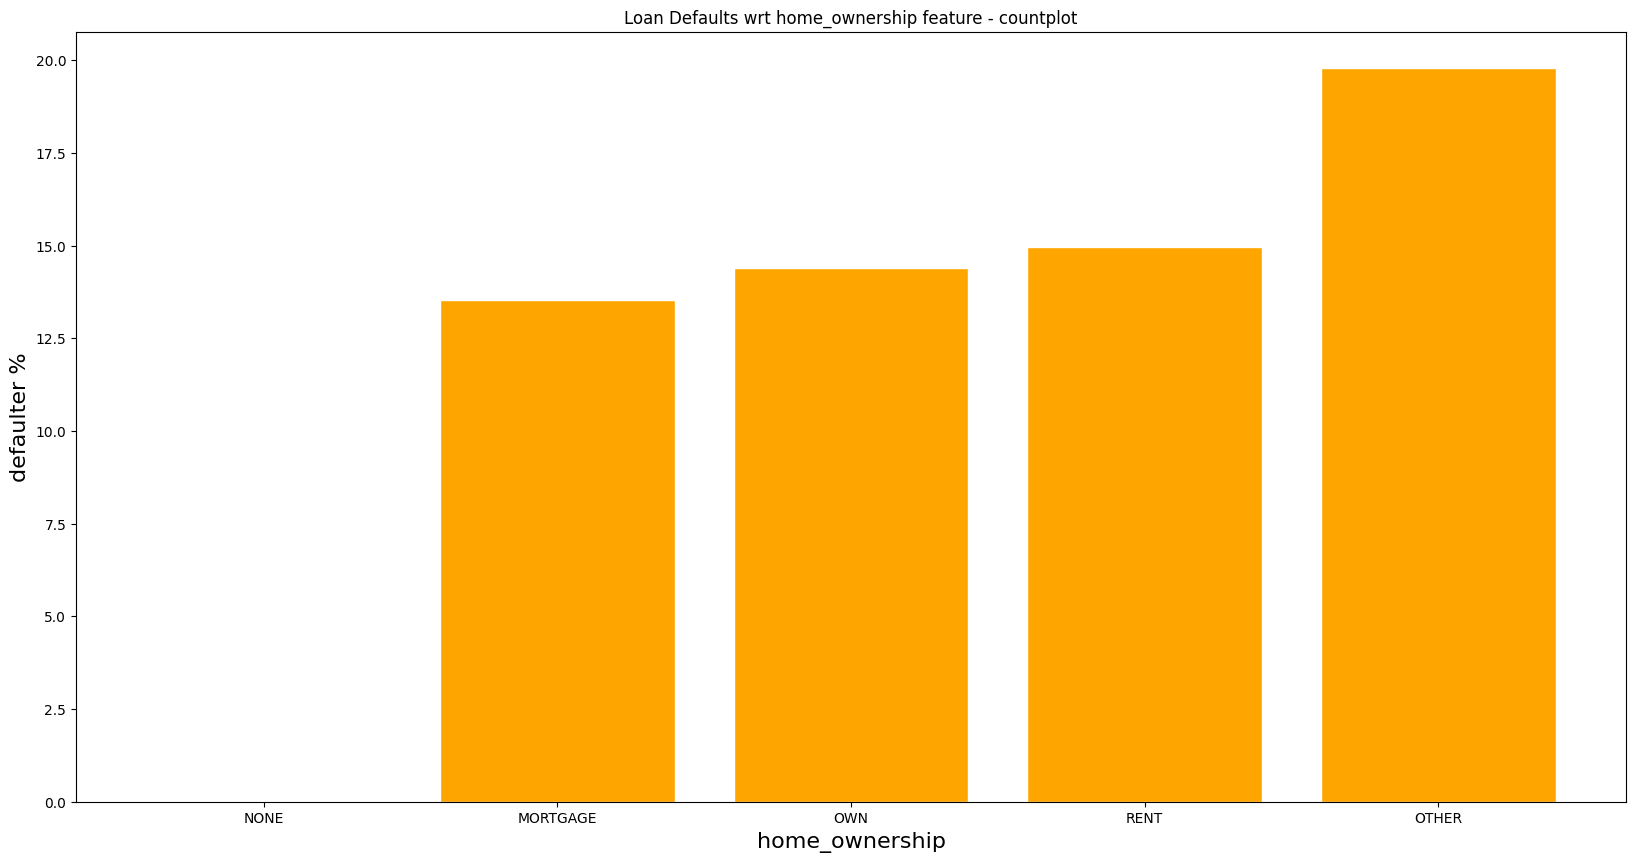

In [201]:
# check for defaulters wrt home_ownership in the data 
plotUnivariateRatioBarSegmentedByDefaulter("home_ownership")

From above plot for `home_ownership` we can infer that the defaulters rate is almost constant here (it is quite more for OTHERS but we dont know what is in there, so we’ll not consider it for analysis), hence defaulter does not depends on `home_ownership`

In [202]:
#get verification_status values
loan["verification_status"].value_counts()

verification_status
Not Verified       15702
Verified           11476
Source Verified     9210
Name: count, dtype: int64

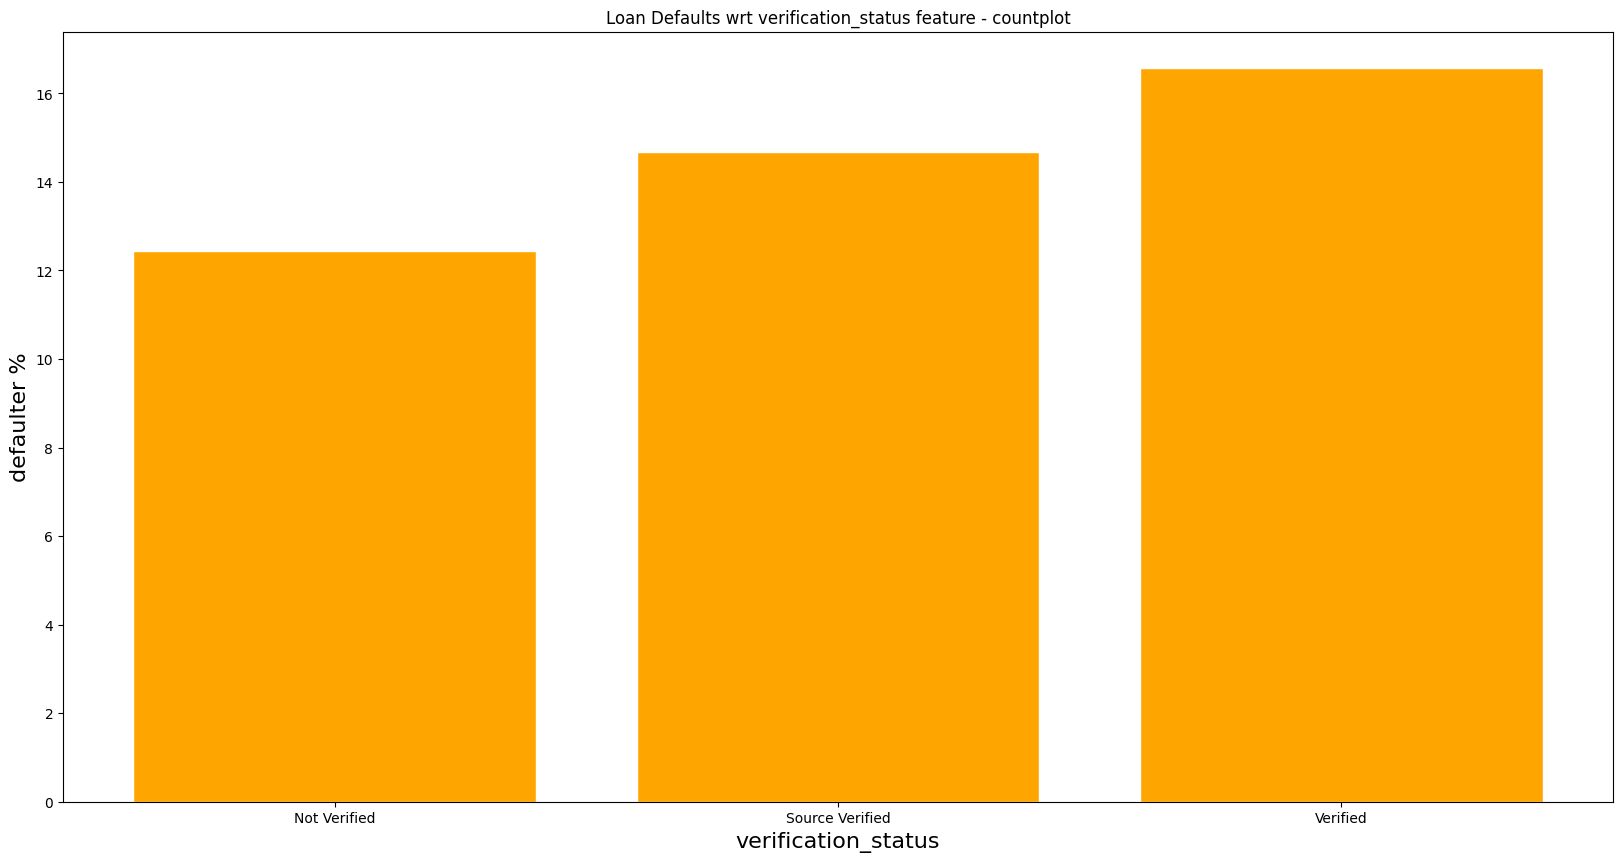

In [203]:
# check for defaulters wrt verification_status in the data
plotUnivariateRatioBarSegmentedByDefaulter("verification_status")

From above plot for `verification_status` we can infer that the defaulters rate is increasing and is less for Not Verified users than Verified ones, but not useful for analysis.

but we can not deduce that verified users are likely to be defaulter.

In [204]:
#get purpose values
loan["purpose"].value_counts()

purpose
debt_consolidation    17664
credit_card            4897
other                  3700
home_improvement       2782
major_purchase         2074
small_business         1709
car                    1446
wedding                 912
medical                 654
moving                  550
Name: count, dtype: int64

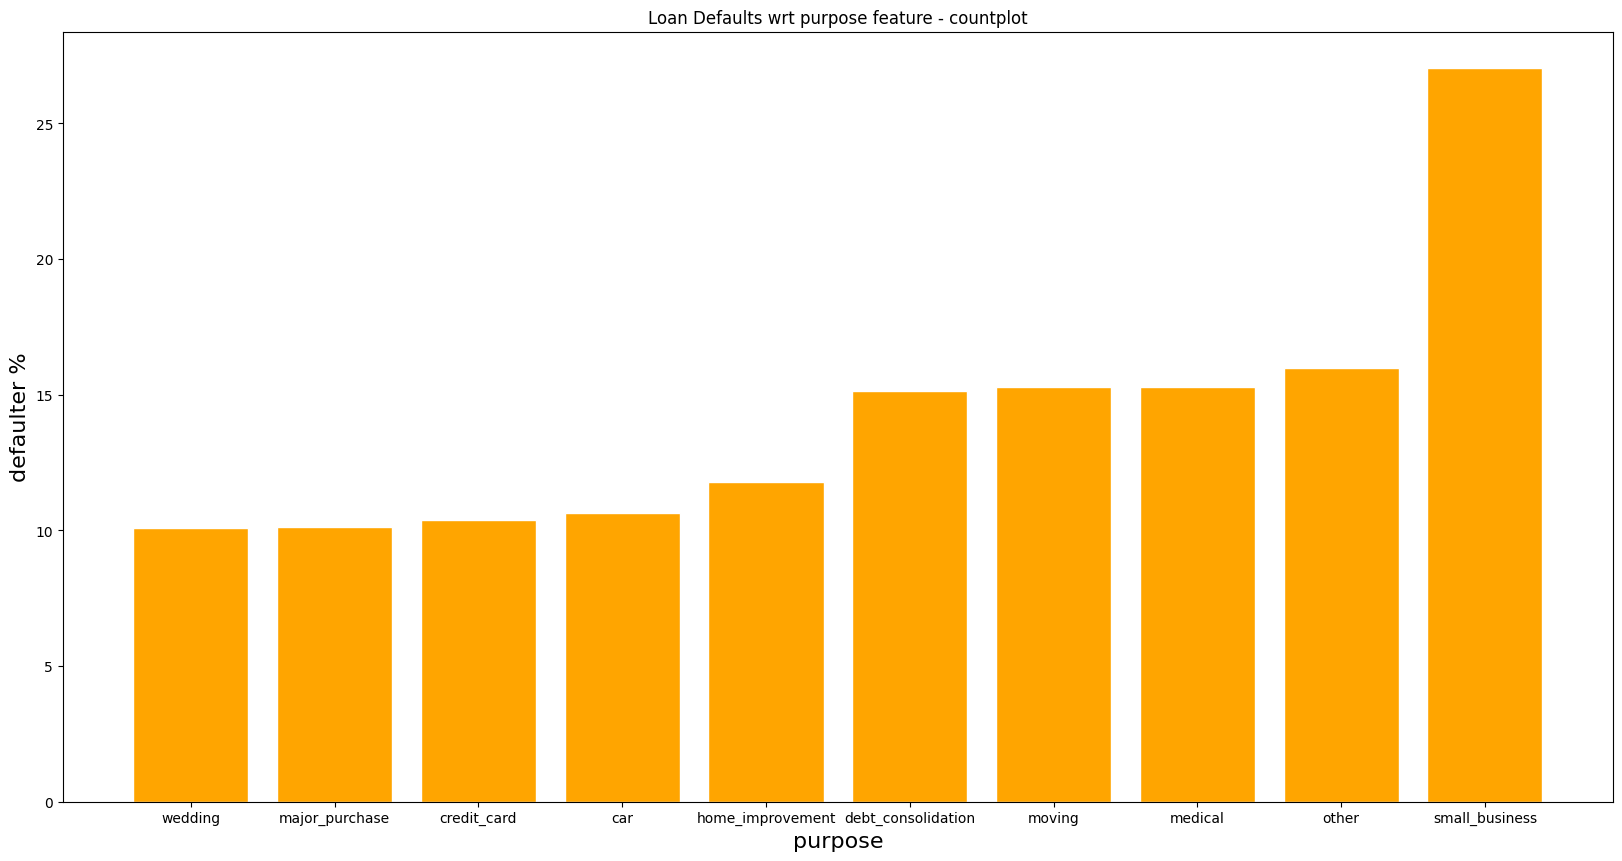

In [205]:
# check for defaulters wrt purpose in the data using countplot
plotUnivariateRatioBarSegmentedByDefaulter("purpose")

From above plot for `purpose` we can infer that the defaulters rate is nearly constant for all purpose type except ‘small business’, hence rate will depend on purpose of the loan.

In [206]:
#get open_acc values
loan["open_acc"].value_counts()

open_acc
7     3720
6     3599
8     3598
9     3442
10    2958
5     2868
11    2544
4     2136
12    2108
13    1777
14    1343
3     1334
15    1088
16     876
17     677
2      506
18     493
19     369
20     268
21     221
22     126
23      89
24      68
25      51
26      29
28      24
27      22
30      13
29      13
31       7
34       5
32       3
33       3
35       3
36       2
39       1
38       1
44       1
41       1
42       1
Name: count, dtype: int64

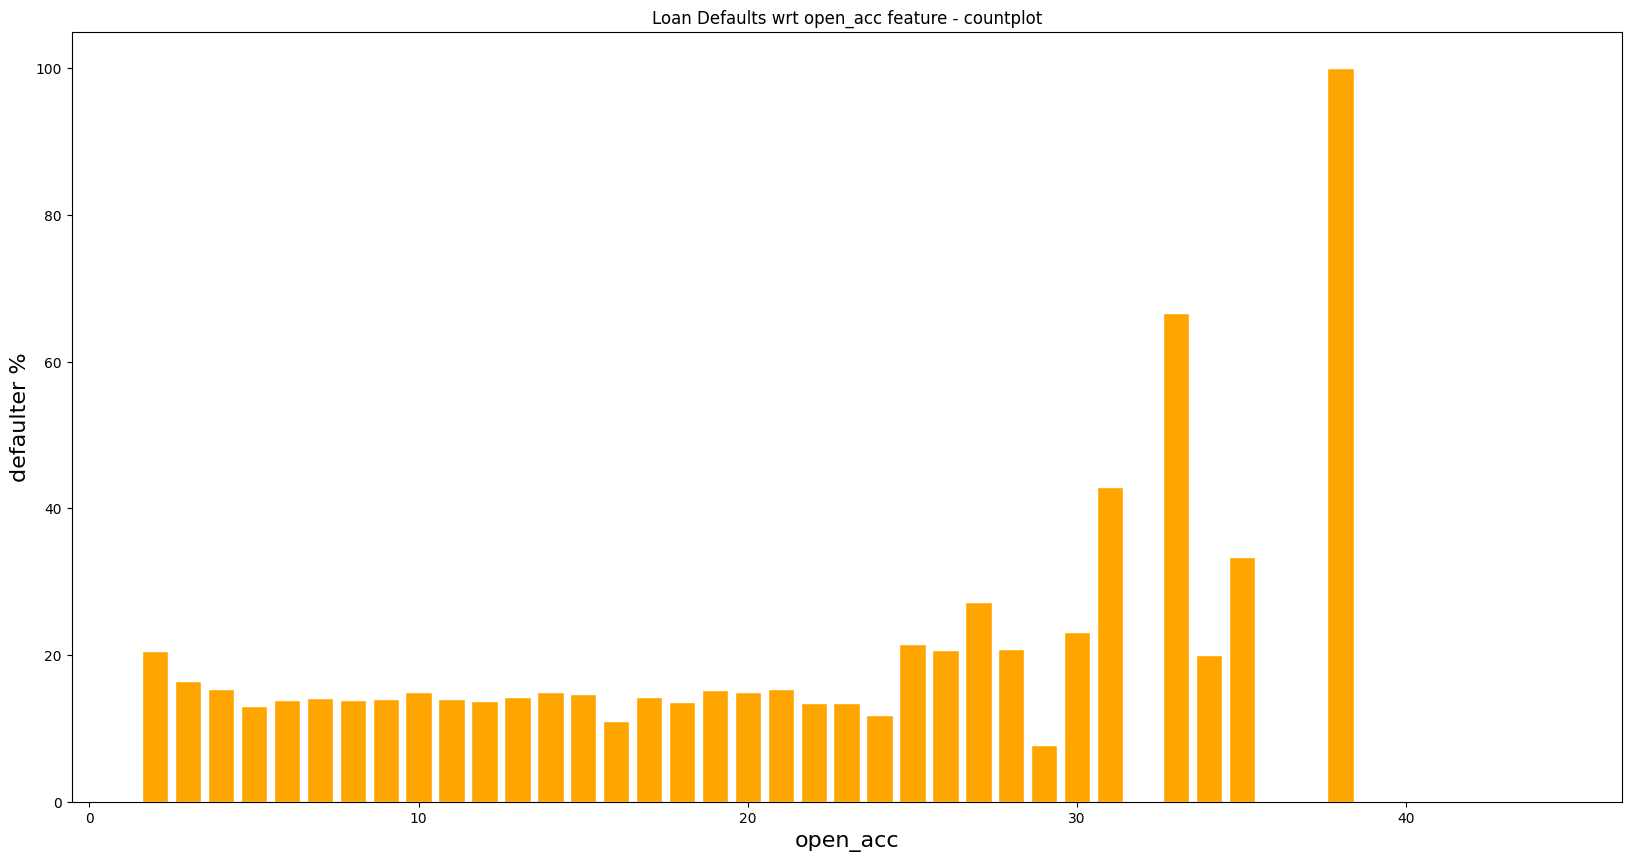

In [207]:
# check for defaulters wrt open_acc in the data using countplot
plotUnivariateRatioBarSegmentedByDefaulter("open_acc")

From above plot for `open_acc` we can infer that the defaulters rate is nearly constant for feature open_acc, hence rate will not depend on open_acc feature ie. The number of open credit lines in the borrower's credit file doesn't qualify loan approval metric.

In [208]:
#get pub_rec values
loan["pub_rec"].value_counts()

pub_rec
0    34503
1     1830
2       46
3        7
4        2
Name: count, dtype: int64

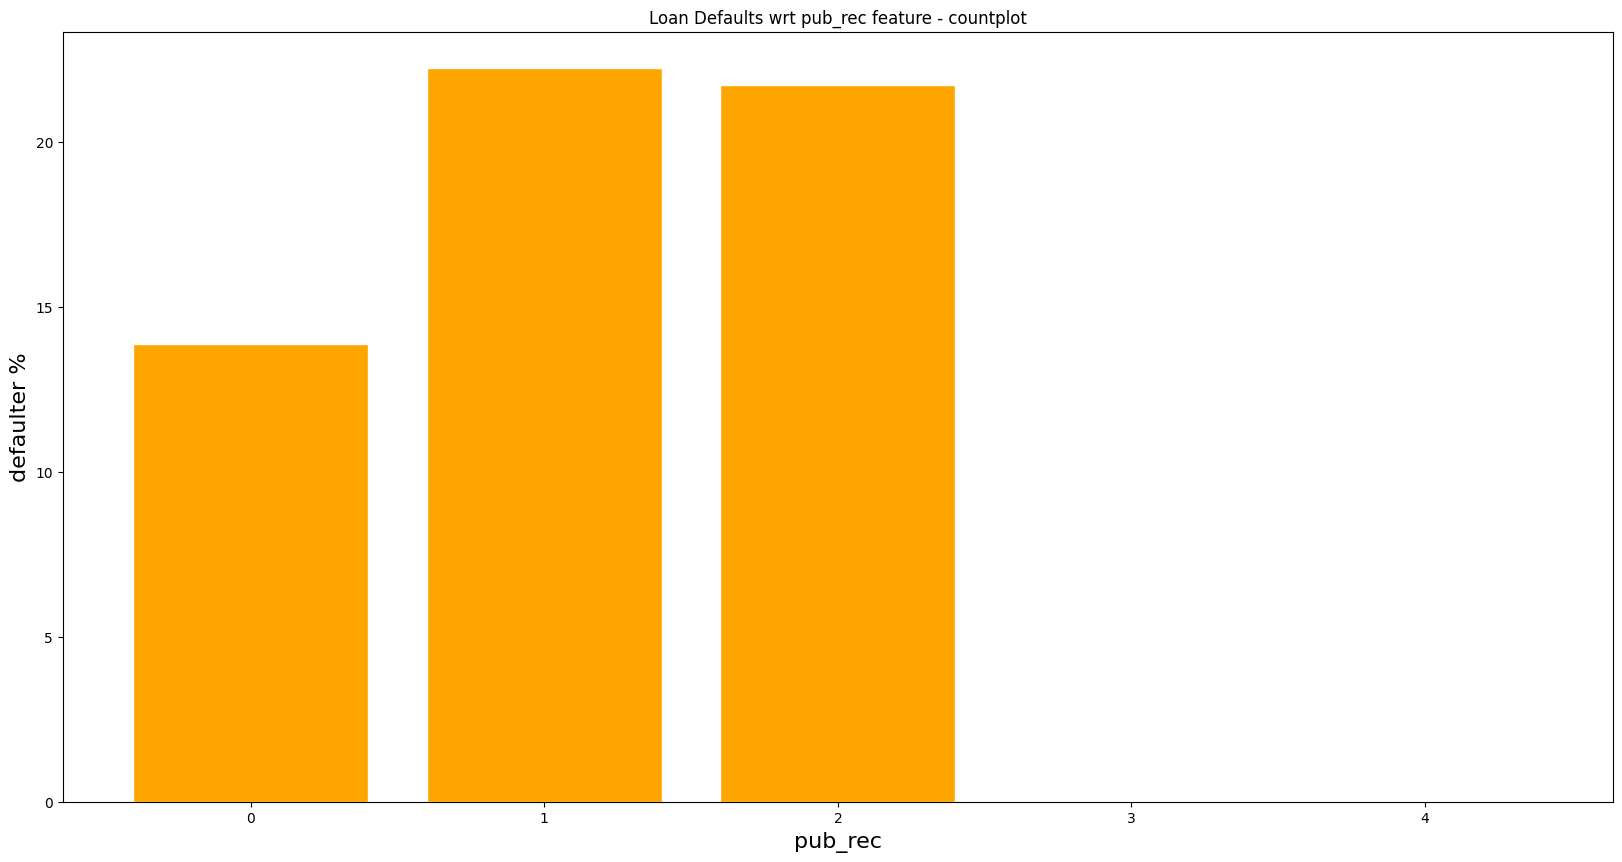

In [209]:
# check for defaulters wrt pub_rec in the data using countplot
plotUnivariateRatioBarSegmentedByDefaulter("pub_rec")

From above plot for `pub_rec` we can infer that the defaulters rate is nearly increasing as it is less for 0 and more for pub_rec with value 1, but as other values are very less as compared to 0 we’ll not consider this for analysis.

In [210]:
#get pub_rec_bankruptcies values
loan["pub_rec_bankruptcies"].value_counts()

pub_rec_bankruptcies
0.0    34233
1.0     1482
2.0        5
Name: count, dtype: int64

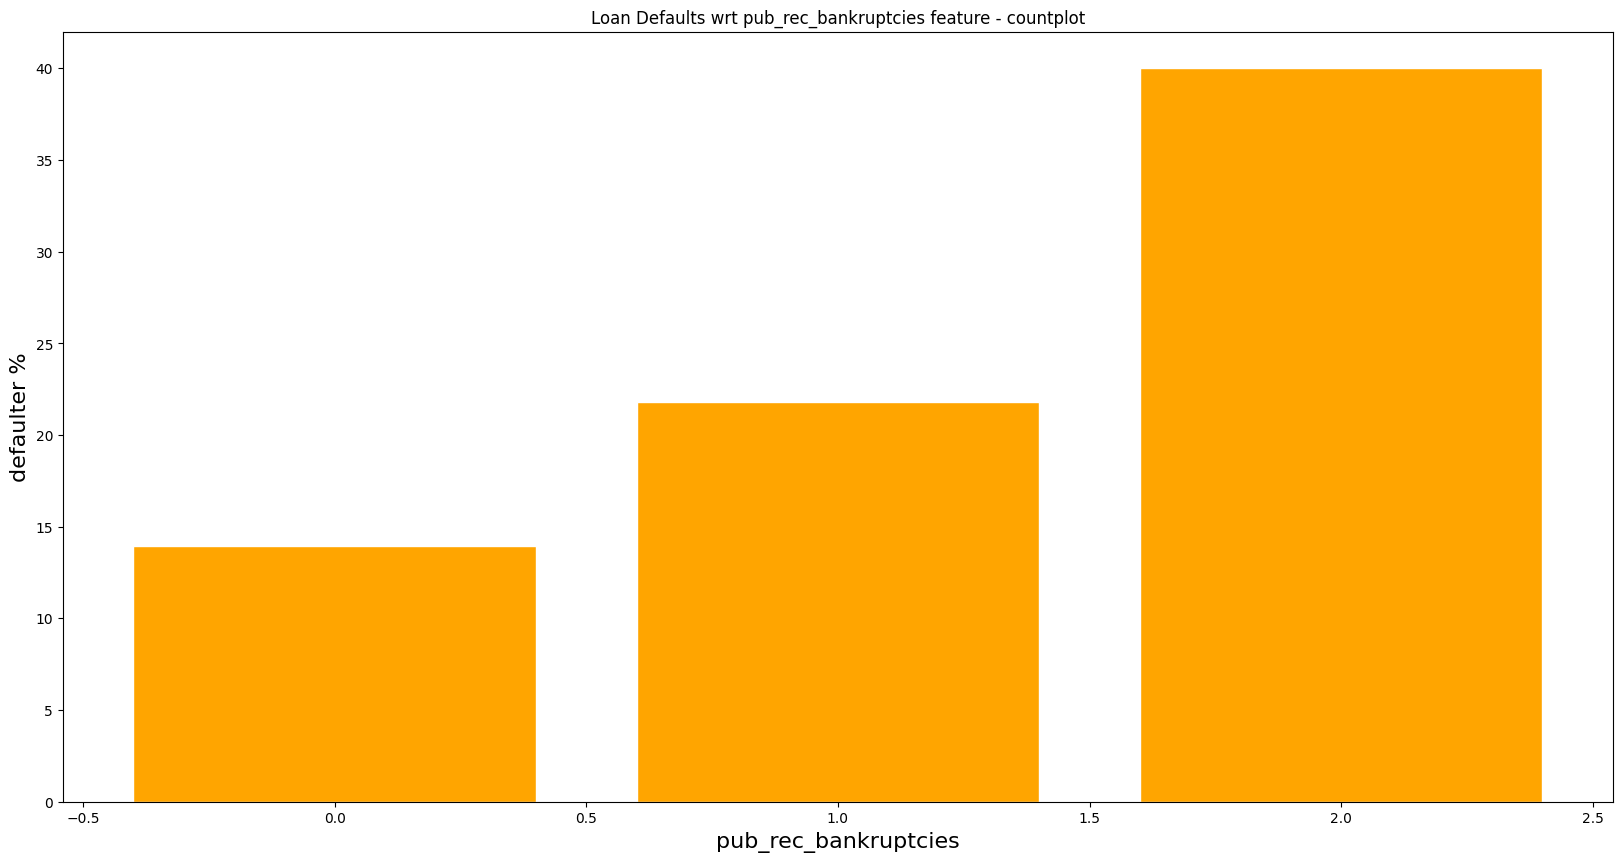

In [211]:
# check for defaulters wrt pub_rec_bankruptcies in the data using countplot
plotUnivariateRatioBarSegmentedByDefaulter("pub_rec_bankruptcies")

From above plot for `pub_rec_bankruptcies` we can infer that the defaulters rate is nearly increasing as it is less for 0 and more for pub_rec_bankruptcies with value 1, but as other values are very less as compared to 0 we’ll not consider this for analysis.

b. Continuous Features

In [212]:
#get emp_length values
loan["emp_length"].value_counts()

emp_length
10    8251
0     4355
2     4151
3     3893
4     3221
5     3095
1     3065
6     2115
7     1654
8     1400
9     1188
Name: count, dtype: int64

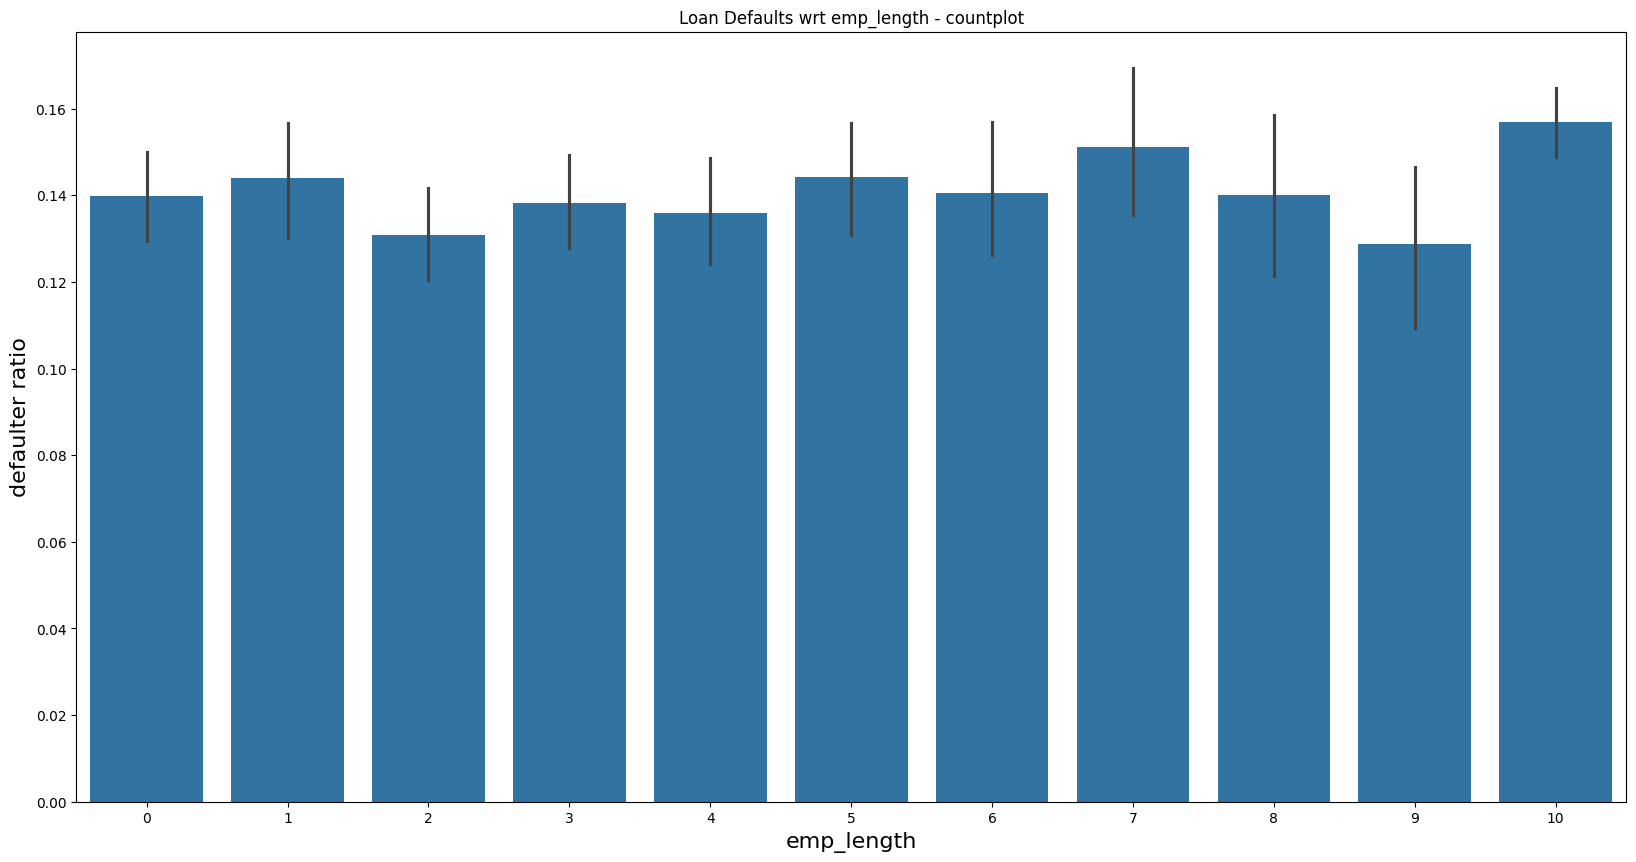

In [213]:
# check for defaulters wrt emp_length in the data using countplot
plotUnivariateBarSegmentedByDefaulter("emp_length")

From above plot for `emp_length` we can infer that the defaulters rate is constant here, hence defaulter does not depends on Employment length in years.

In [214]:
#get month value counts
loan["issue_d_month"].value_counts()

issue_d_month
12    4016
11    3788
10    3519
9     3287
8     3230
7     3147
6     2986
5     2742
4     2666
3     2538
1     2261
2     2208
Name: count, dtype: int64

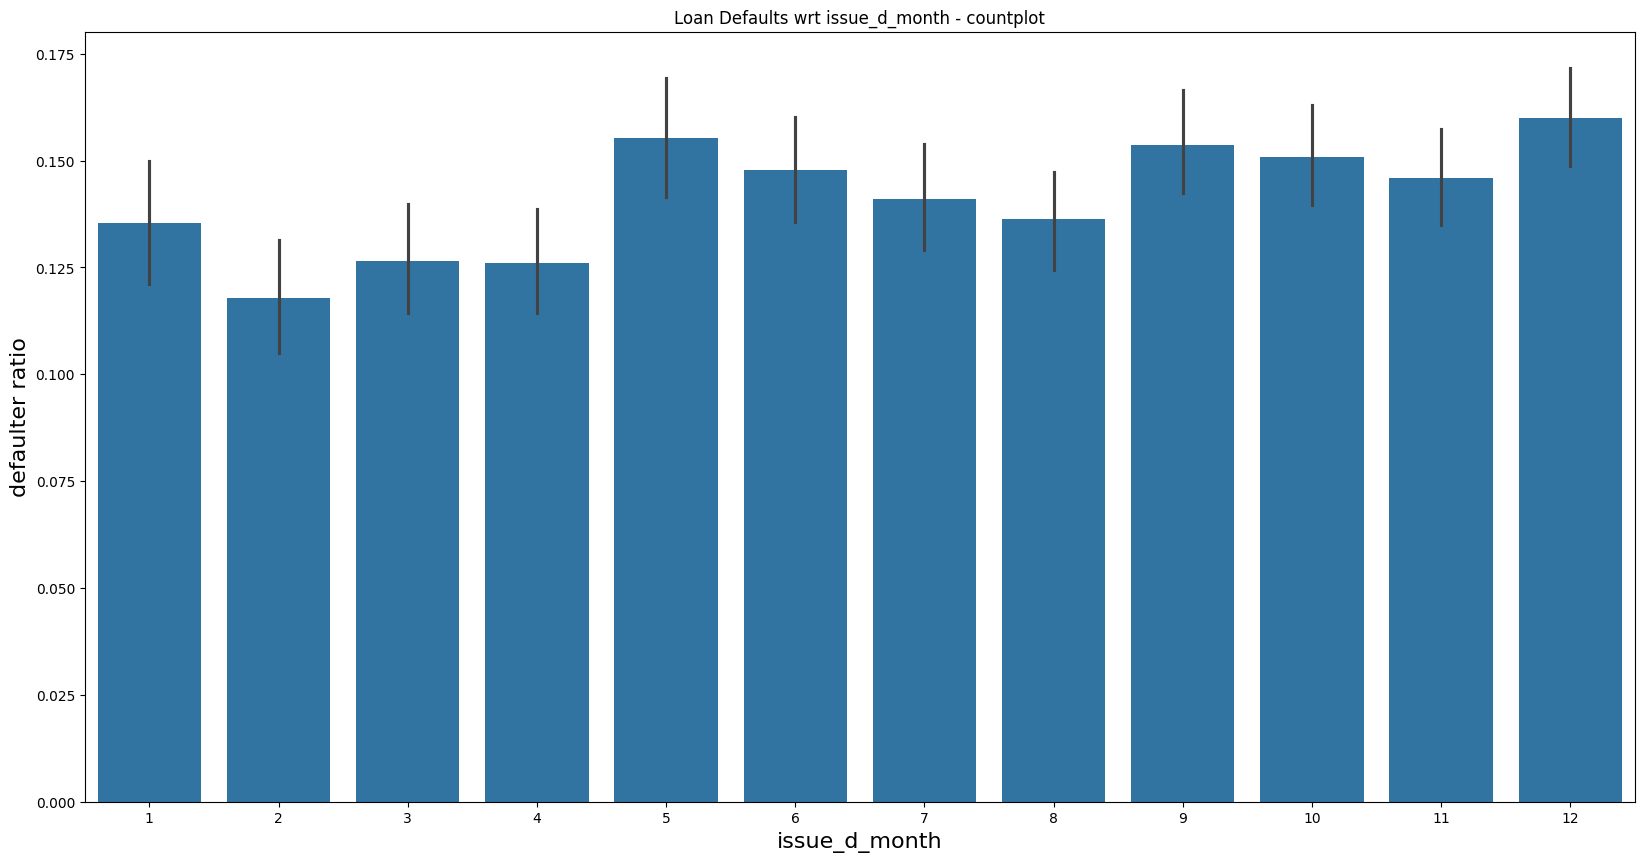

In [215]:
# check for defaulters wrt month in the data using countplot
plotUnivariateBarSegmentedByDefaulter("issue_d_month")

From above plot for `month` we can infer that the defaulters rate is nearly constant here, hence not useful

In [216]:
#get year value counts
loan["issue_d_year"].value_counts()

issue_d_year
2011    19350
2010    10873
2009     4453
2008     1477
2007      235
Name: count, dtype: int64

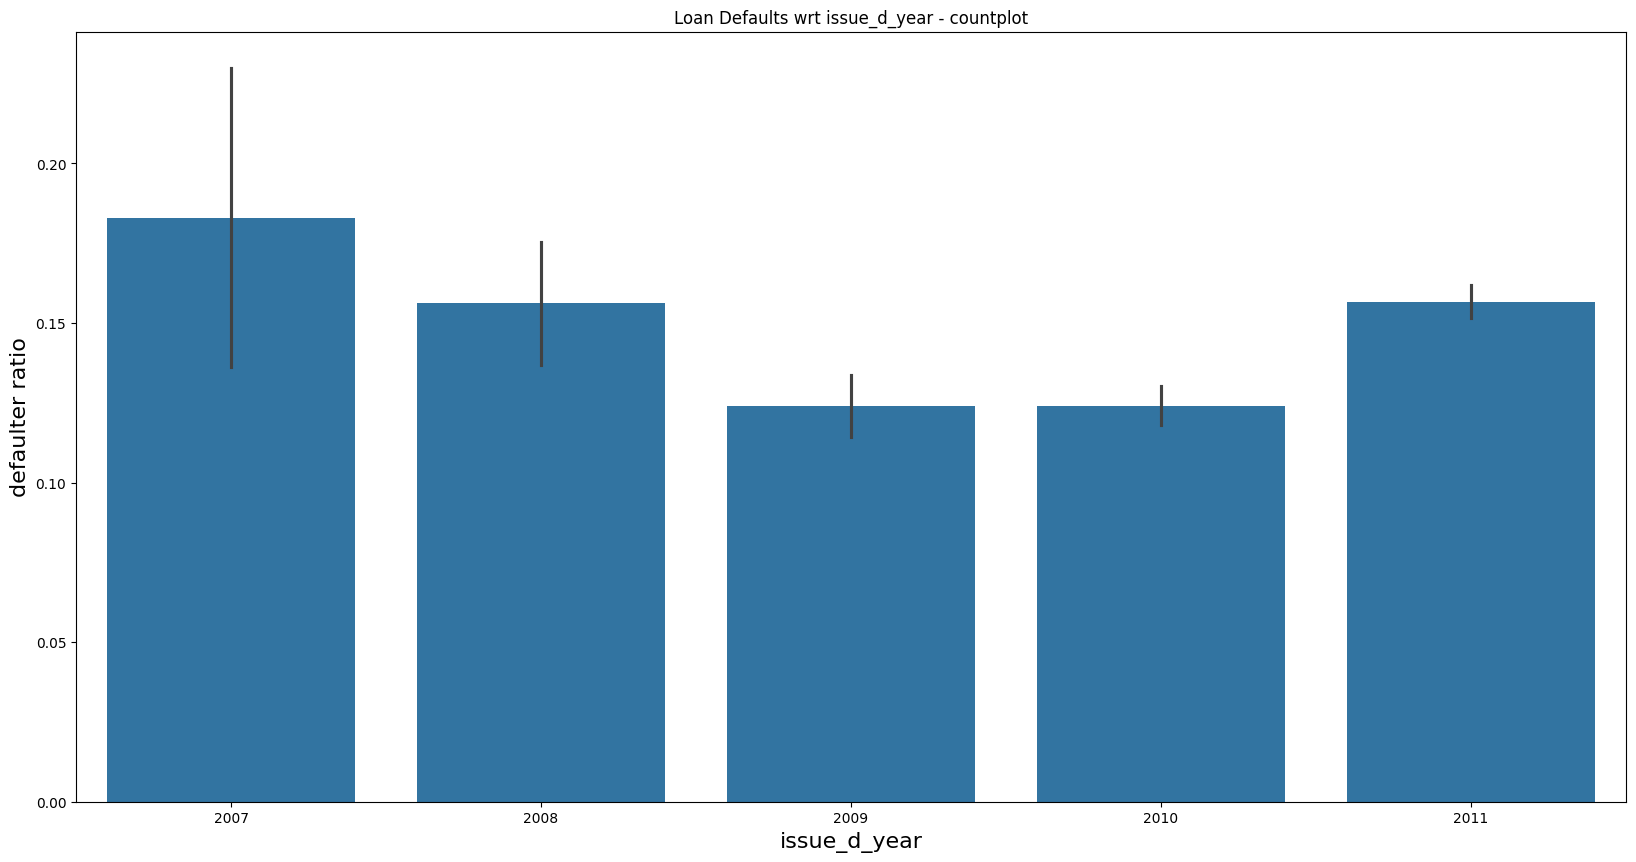

In [217]:
# check for defaulters wrt year in the data using countplot
plotUnivariateBarSegmentedByDefaulter("issue_d_year")

From above plot for `year` we can infer that the defaulters rate is nearly constant here, hence not useful for analysis.

In [218]:
#get earliest_cr_line value counts
loan["earliest_cr_line_year"].value_counts()

earliest_cr_line_year
2000    3016
1999    2770
1998    2637
2001    2348
1997    2263
1996    2094
1995    1983
1994    1863
2002    1784
2003    1732
2004    1657
1993    1377
2005    1370
2006    1062
1992     985
1990     950
1991     900
1989     777
2007     659
1988     659
1987     559
1986     437
1985     403
1984     365
1983     302
1982     192
1981     160
1980     155
2008     137
1979     136
1978     132
1977      94
1976      75
1975      68
1974      51
1973      44
1971      39
1970      35
1972      35
1969      27
1967      14
1968      14
1966       7
1965       6
1963       6
1962       3
1964       2
1956       1
1946       1
1950       1
1954       1
Name: count, dtype: int64

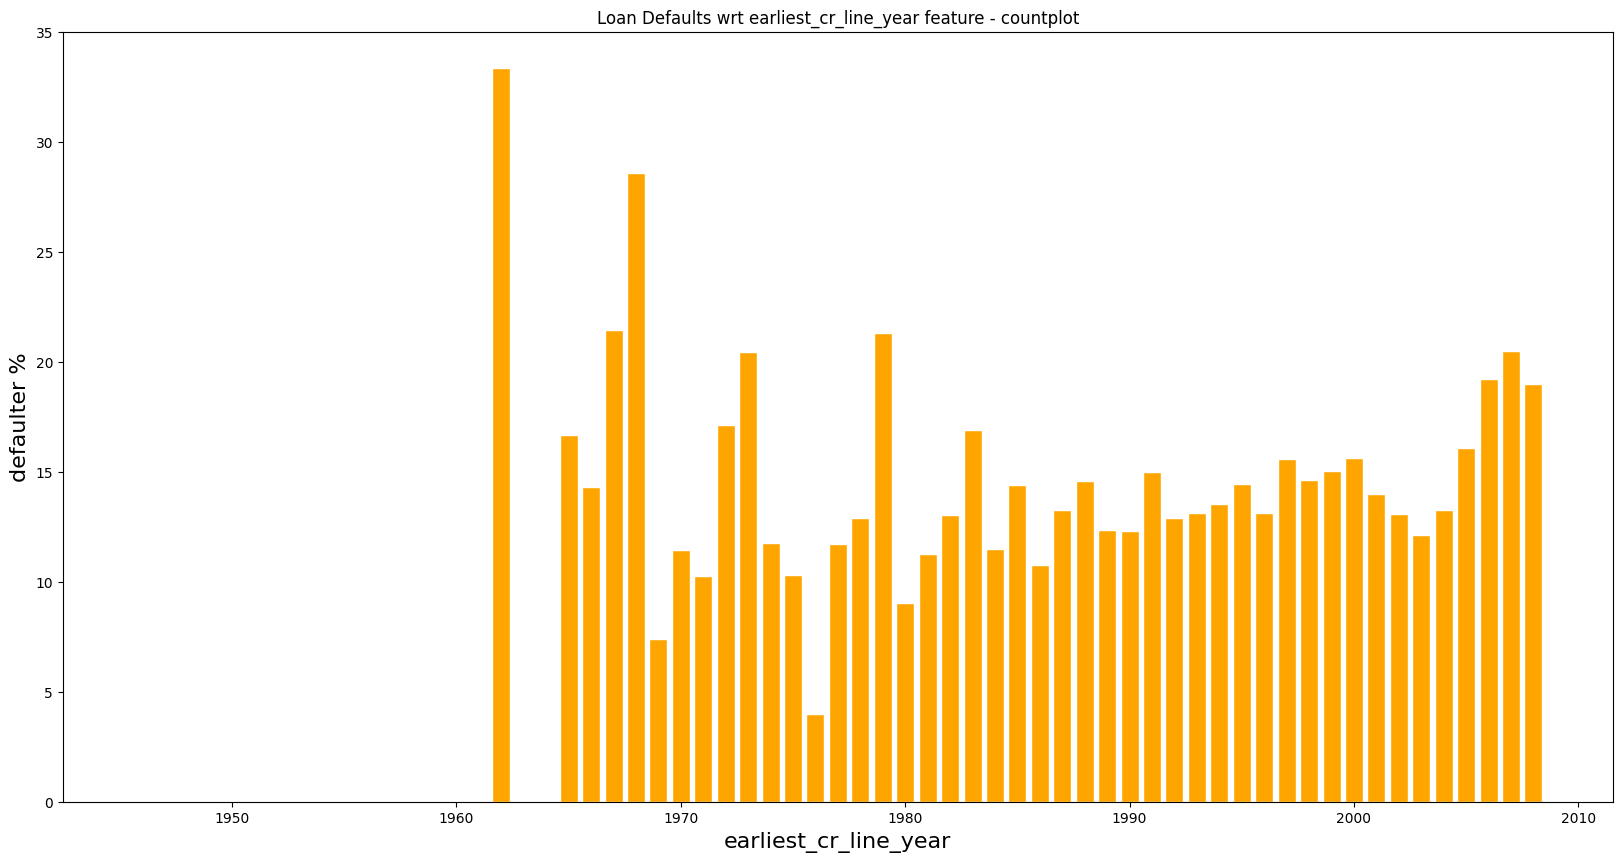

In [219]:
# check for defaulters wrt earliest_cr_line in the data
plotUnivariateRatioBarSegmentedByDefaulter("earliest_cr_line_year")

From above plot for `earliest_cr_line` we can infer that the defaulters rate is nearly constant for all purpose type except year around 65, hence rate does not depends on earliest_cr_line ie. The month the borrower's earliest reported credit line was opened will not be useful for analysis.

In [220]:
#get inq_last_6mths value counts
loan["inq_last_6mths"].value_counts()

inq_last_6mths
0    17723
1    10057
2     5311
3     2778
4      290
5      132
6       57
7       27
8       13
Name: count, dtype: int64

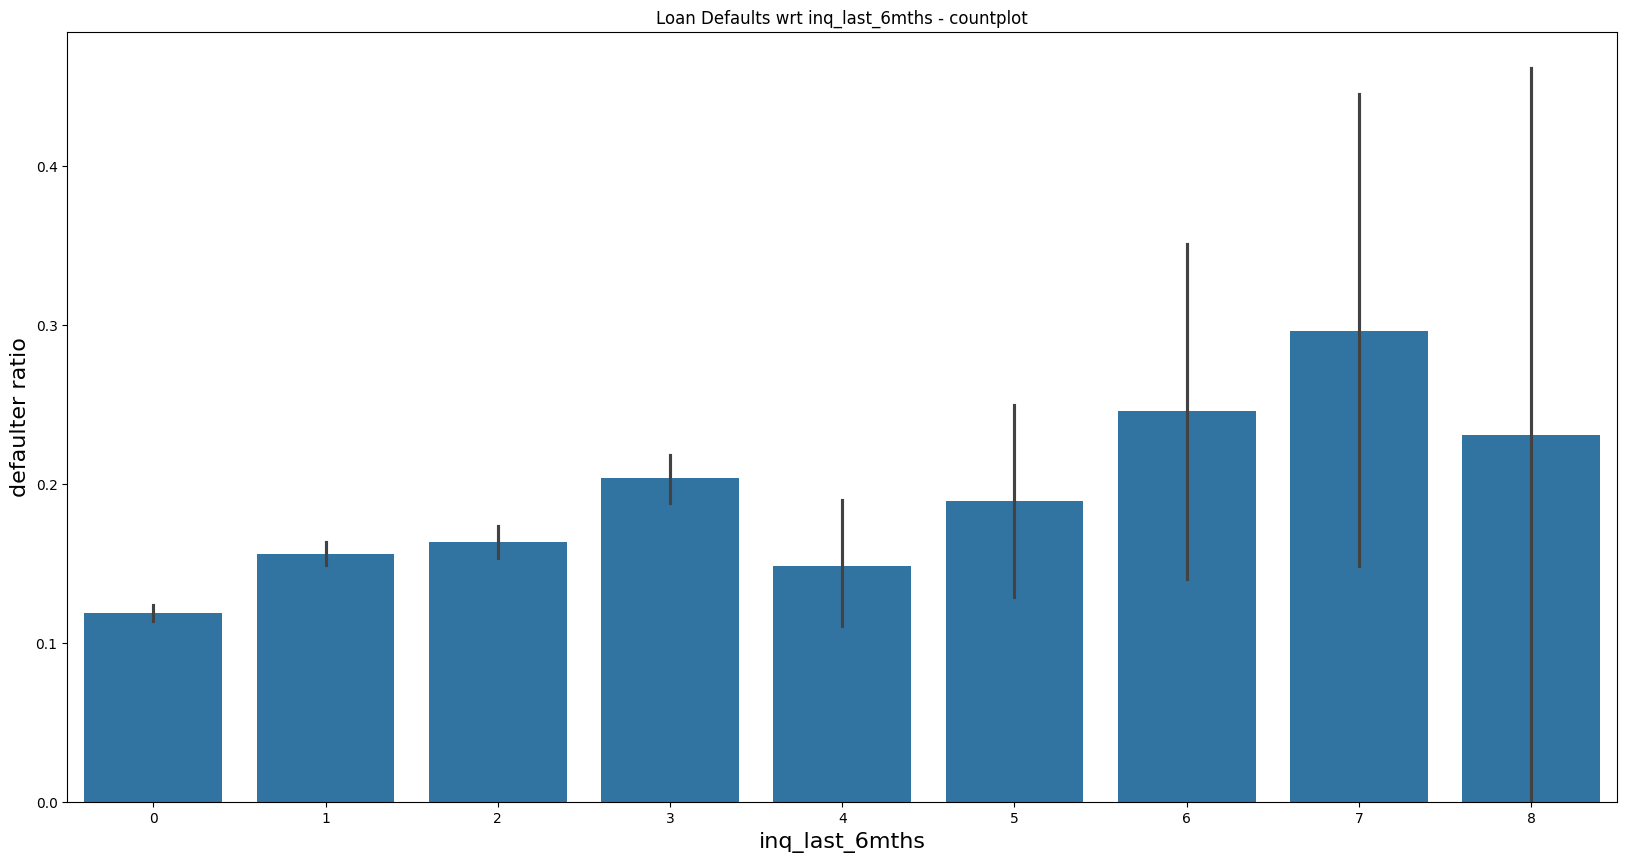

In [221]:
# check for defaulters wrt inq_last_6mths in the data
plotUnivariateBarSegmentedByDefaulter("inq_last_6mths")

From above plot for `inq_last_6mths` we can infer that the defaulters rate is not consistently increasing with inq_last_6mths ie. The number of inquiries in past 6 months (excluding auto and mortgage inquiries), hence not useful for analysis.

From above plot for `revol_util` we can infer that the defaulters rate is fluctuating where some have complete 100% ratio for defaulter and is increasing as the magnitude increases, hence rate will depend on revol_util feature ie. Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit is useful feature for loan analysis.

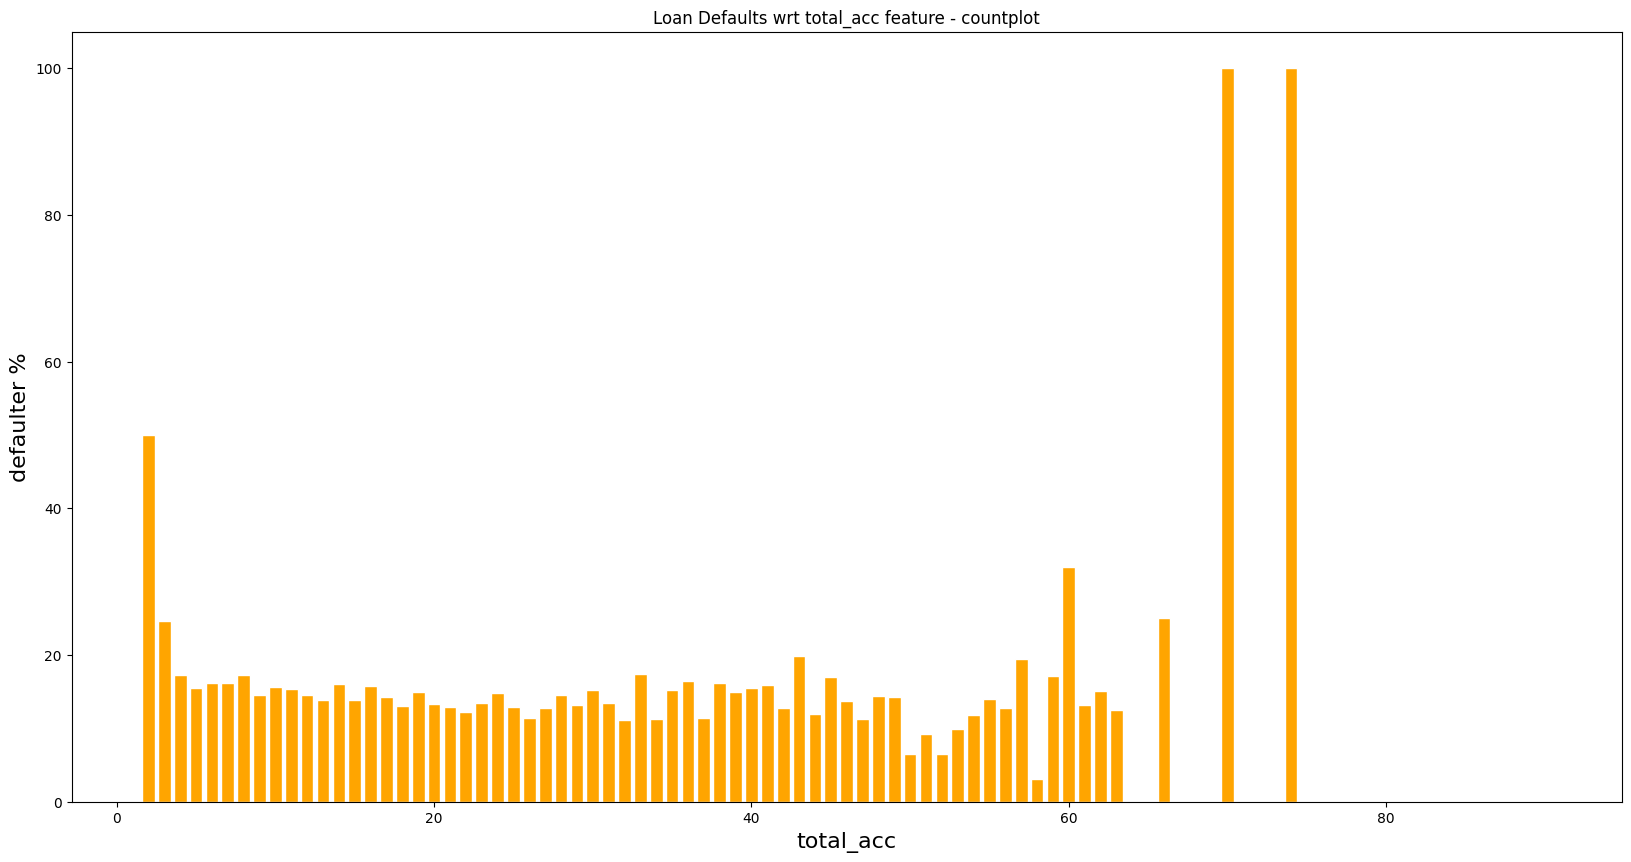

In [222]:
# check for defaulters wrt total_acc in the data using countplot
plotUnivariateRatioBarSegmentedByDefaulter("total_acc")

From above plot for `total_acc` we can infer that the defaulters rate is nearly constant for all total_acc values ie. The total number of credit lines currently in the borrower's credit file, hence rate will not depend on total_acc feature

### 6.2 Binned Columns for Continuous Data Types

In [223]:
#get revol_util value counts
loan["revol_util_range"].value_counts()

revol_util_range
40    4017
50    3970
60    3953
30    3791
70    3731
20    3474
80    3424
0     3161
10    3076
90    2929
Name: count, dtype: int64

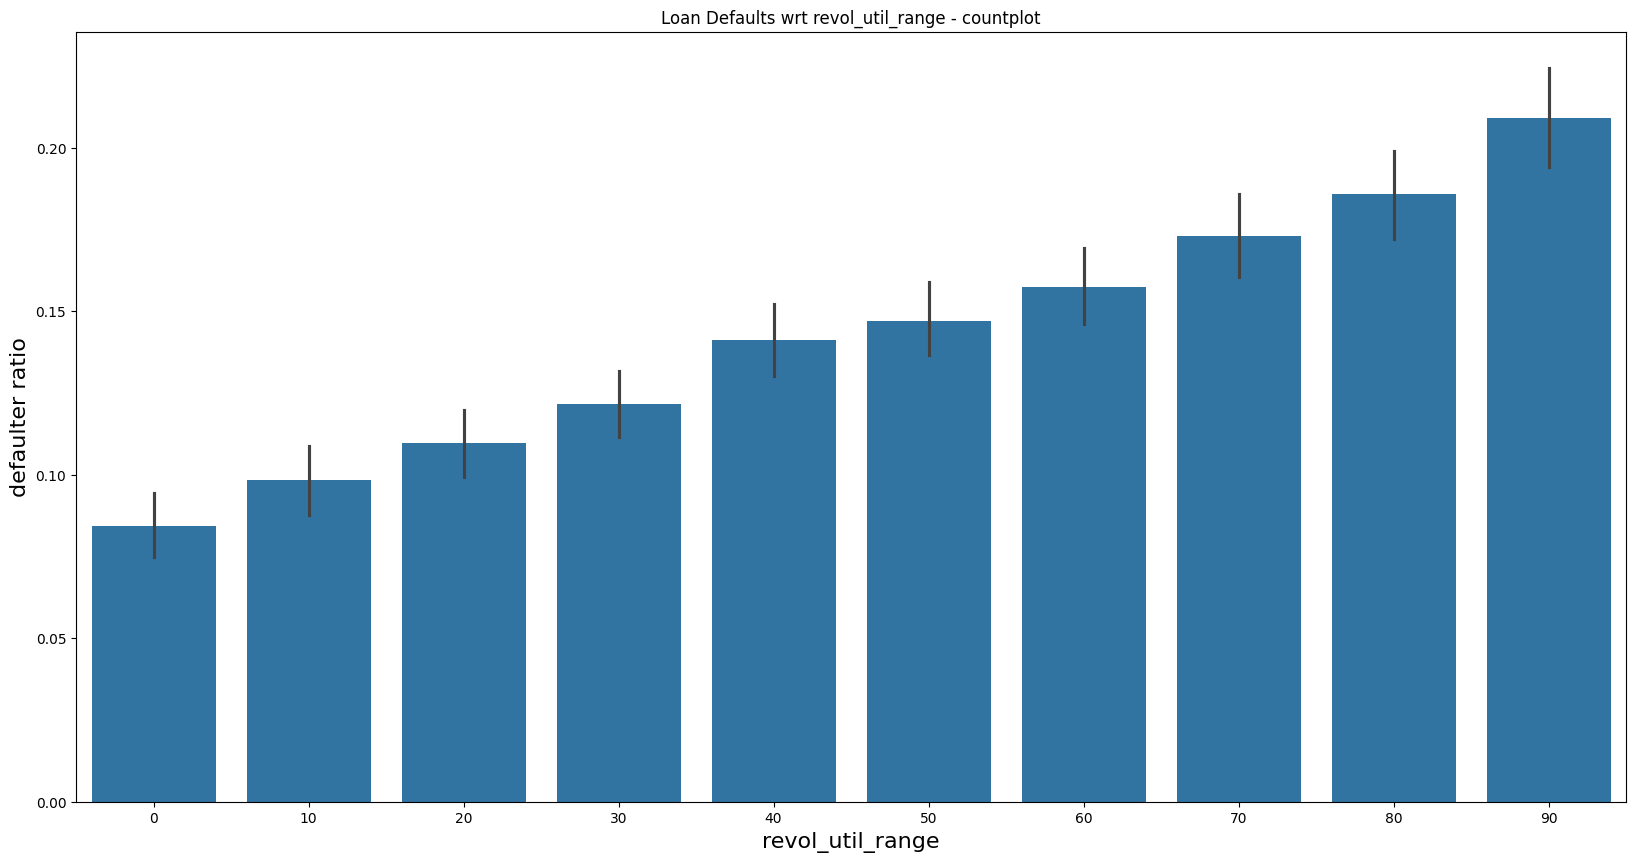

In [224]:
# check for defaulters wrt revol_util in the data using countplot
plotUnivariateBarSegmentedByDefaulter("revol_util_range")

In [225]:
#get loan_amnt_range value counts
loan["loan_amnt_range"].value_counts()

loan_amnt_range
5000-10000     12093
0-5000          8554
10000-15000     7406
15000-20000     4207
20000-25000     2745
25000+          1383
Name: count, dtype: int64

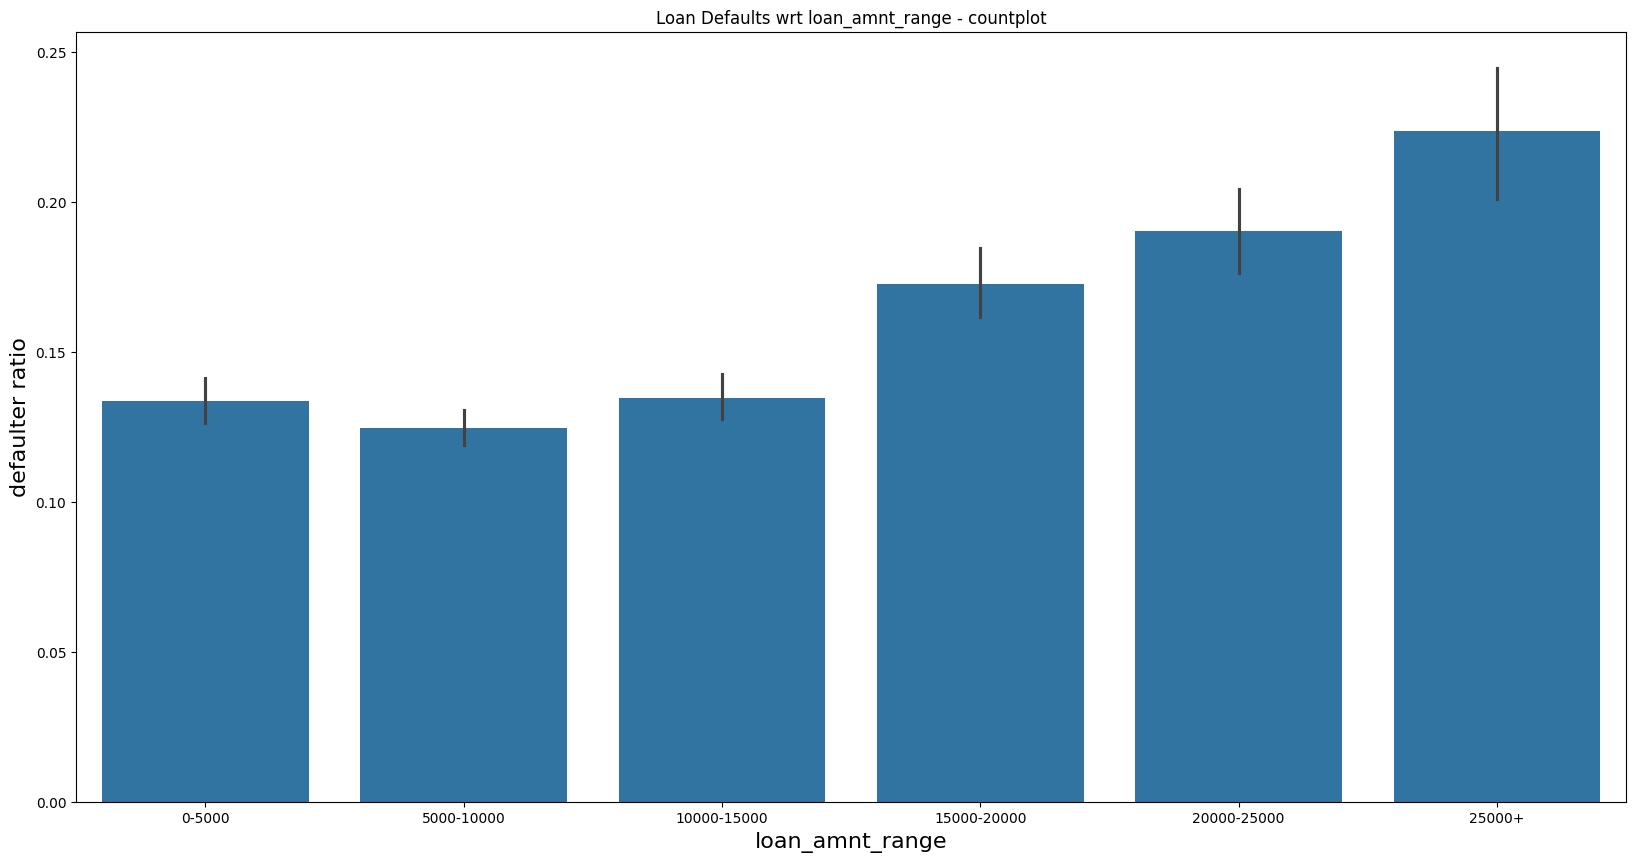

In [226]:
# check for defaulters wrt loan_amnt_range in the data using countplot
plotUnivariateBarSegmentedByDefaulter("loan_amnt_range")    

From above plot for `loan_amnt_range` we can infer that the defaulters rate is increasing with loan_amnt_range values, hence rate will depend on loan_amnt_range feature. so as loan amount range increases chances for loan will be defaulted increases.

In [227]:
#get int_rate_range value counts
loan["int_rate_range"].value_counts()

int_rate_range
10-12.5    8879
12.5-15    8447
15+        7616
7.5-10     6482
0-7.5      4964
Name: count, dtype: int64

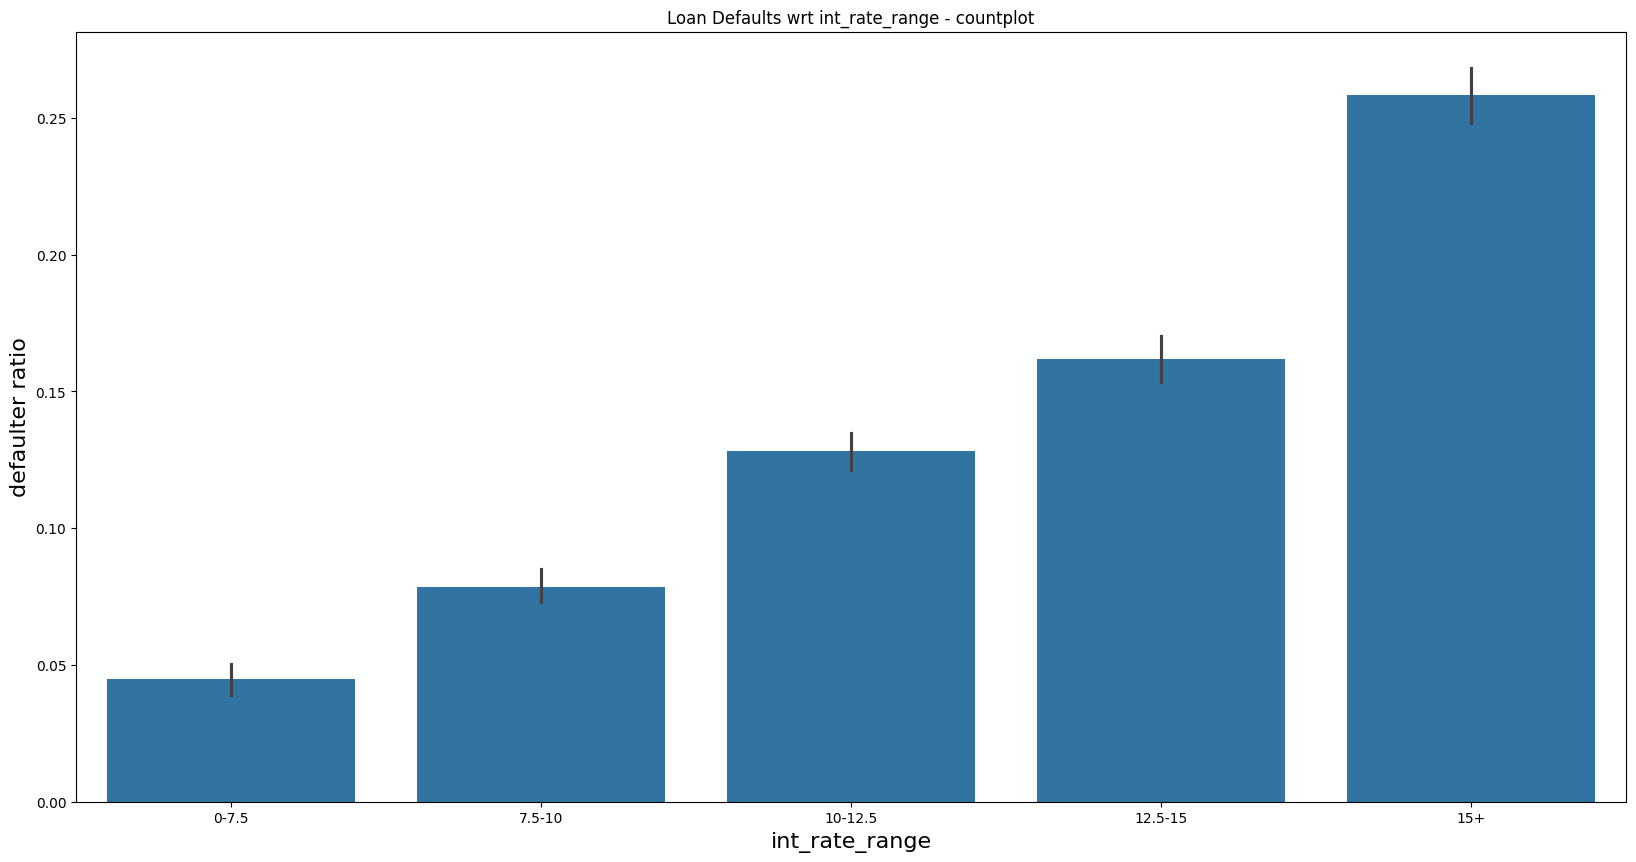

In [228]:
# check for defaulters wrt int_rate_range in the data
plotUnivariateBarSegmentedByDefaulter("int_rate_range")

From above plot for `int_rate_range` we can infer that the defaulters rate is decreasing with int_rate_range values, hence rate will depend on int_rate_range feature

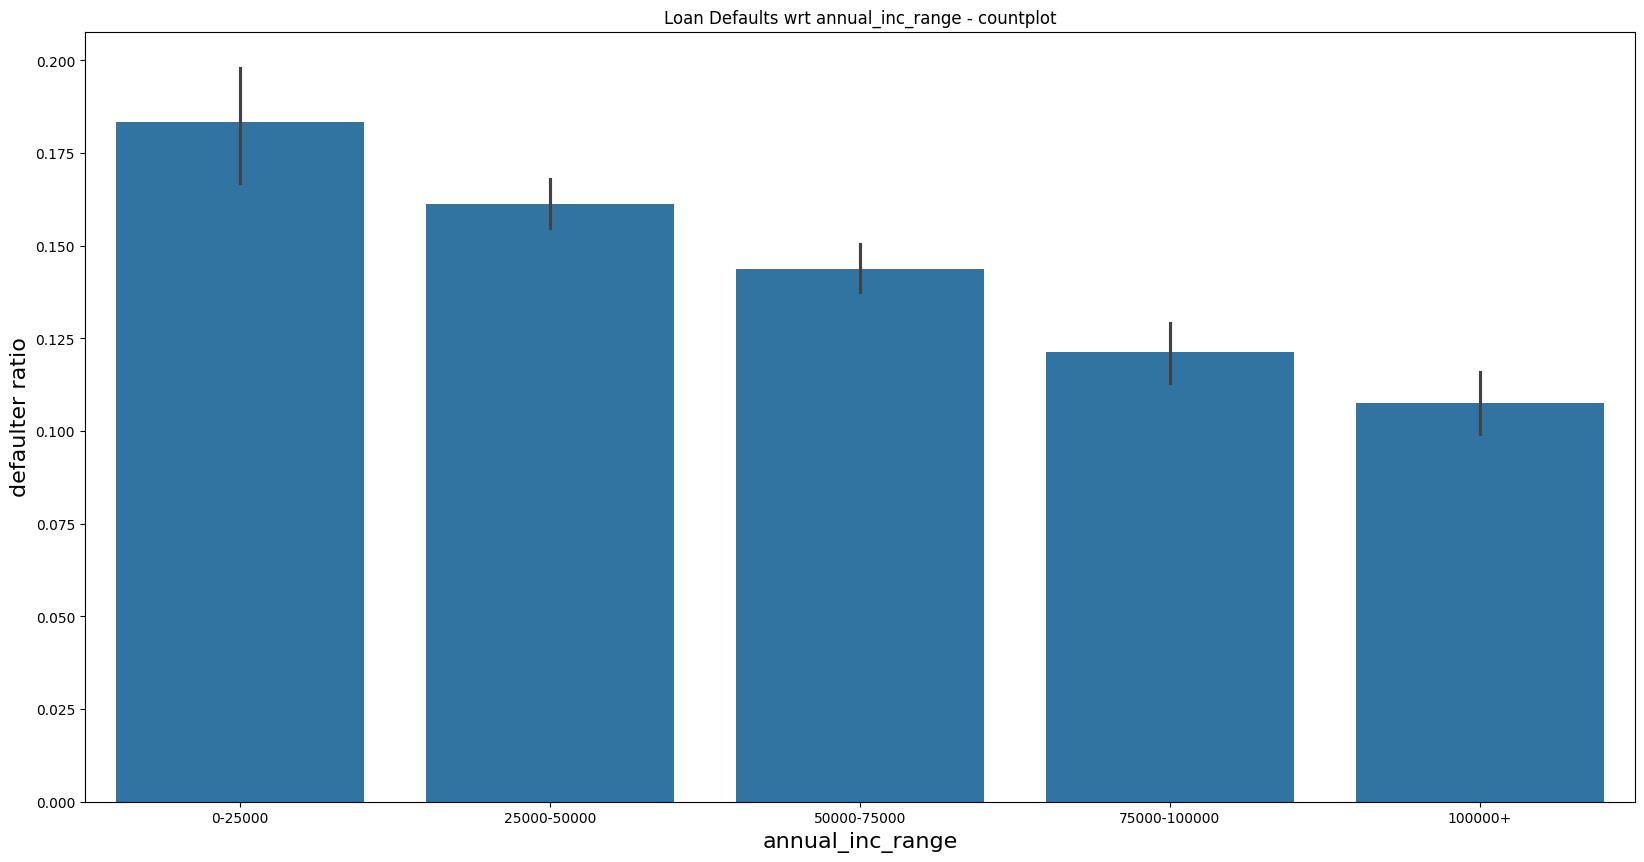

In [229]:
# check for defaulters wrt annual_inc_range in the data
plotUnivariateBarSegmentedByDefaulter("annual_inc_range")

From above plot for `annual_inc_range` we can infer that the defaulters rate is decreasing as with annual_inc_range values, hence rate will depend on annual_inc_range feature.

In [230]:
#get dti_range value counts
loan["dti_range"].value_counts()

dti_range
10-15%    9114
15-20%    8390
5-10%     7407
20-25%    6266
0-5%      4630
25%+       581
Name: count, dtype: int64

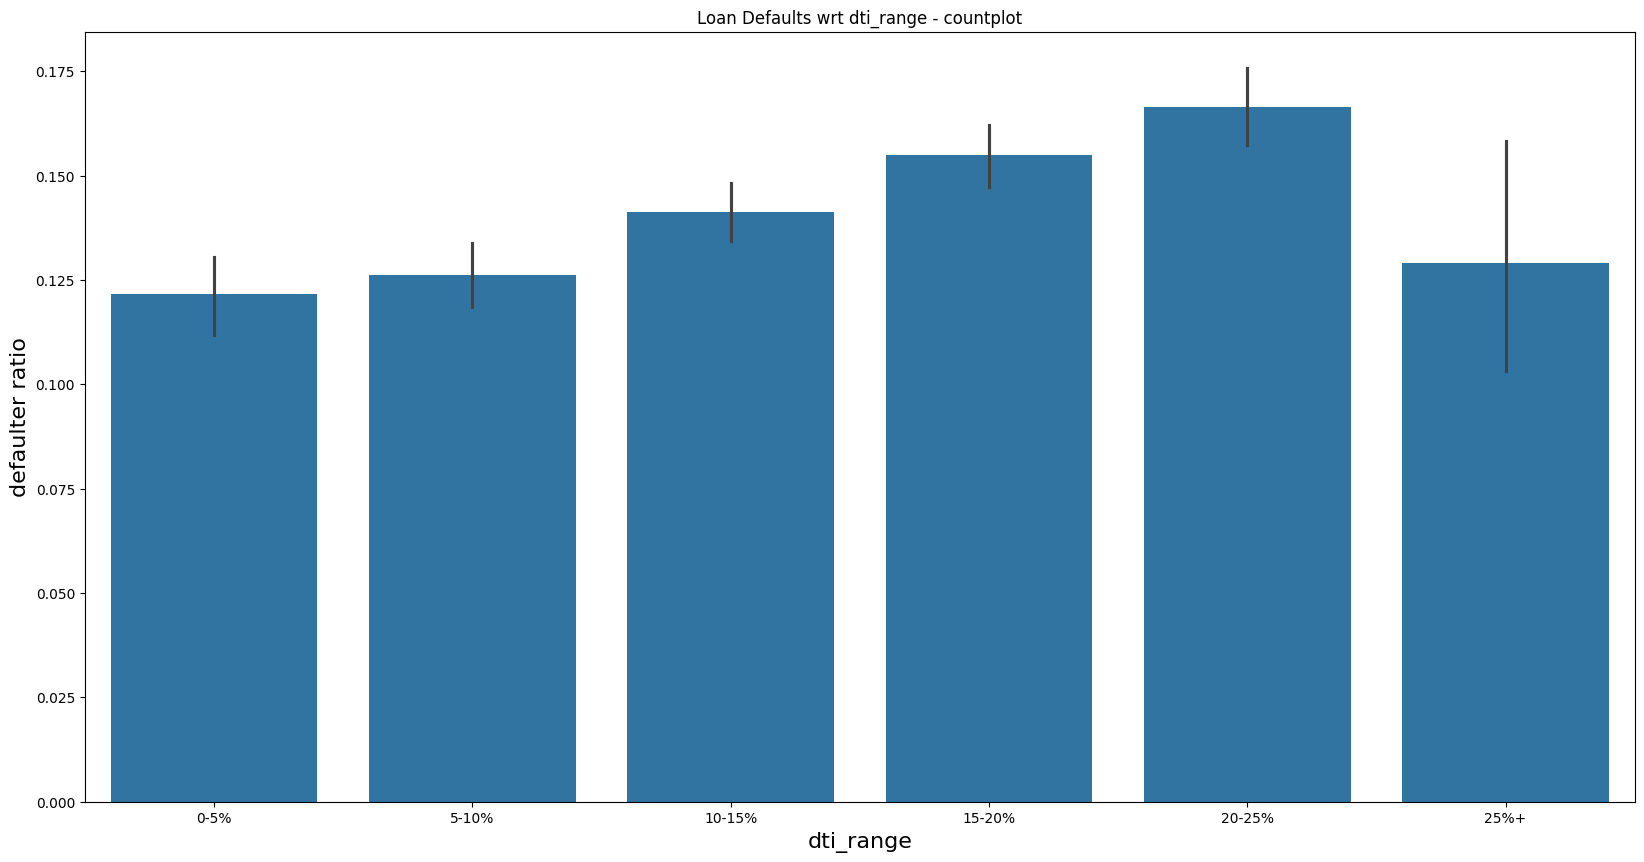

In [231]:
# check for defaulters wrt dti_range in the data using countplot
plotUnivariateBarSegmentedByDefaulter("dti_range")

From above plot for `dti_range` we can infer that the defaulters rate is increasing as with dti_range values, hence rate will depend on dti_range feature.

In [232]:
#get installment value counts
loan["installment_range"].value_counts()

installment_range
medium       17856
low          11932
high          5088
very high     1512
Name: count, dtype: int64

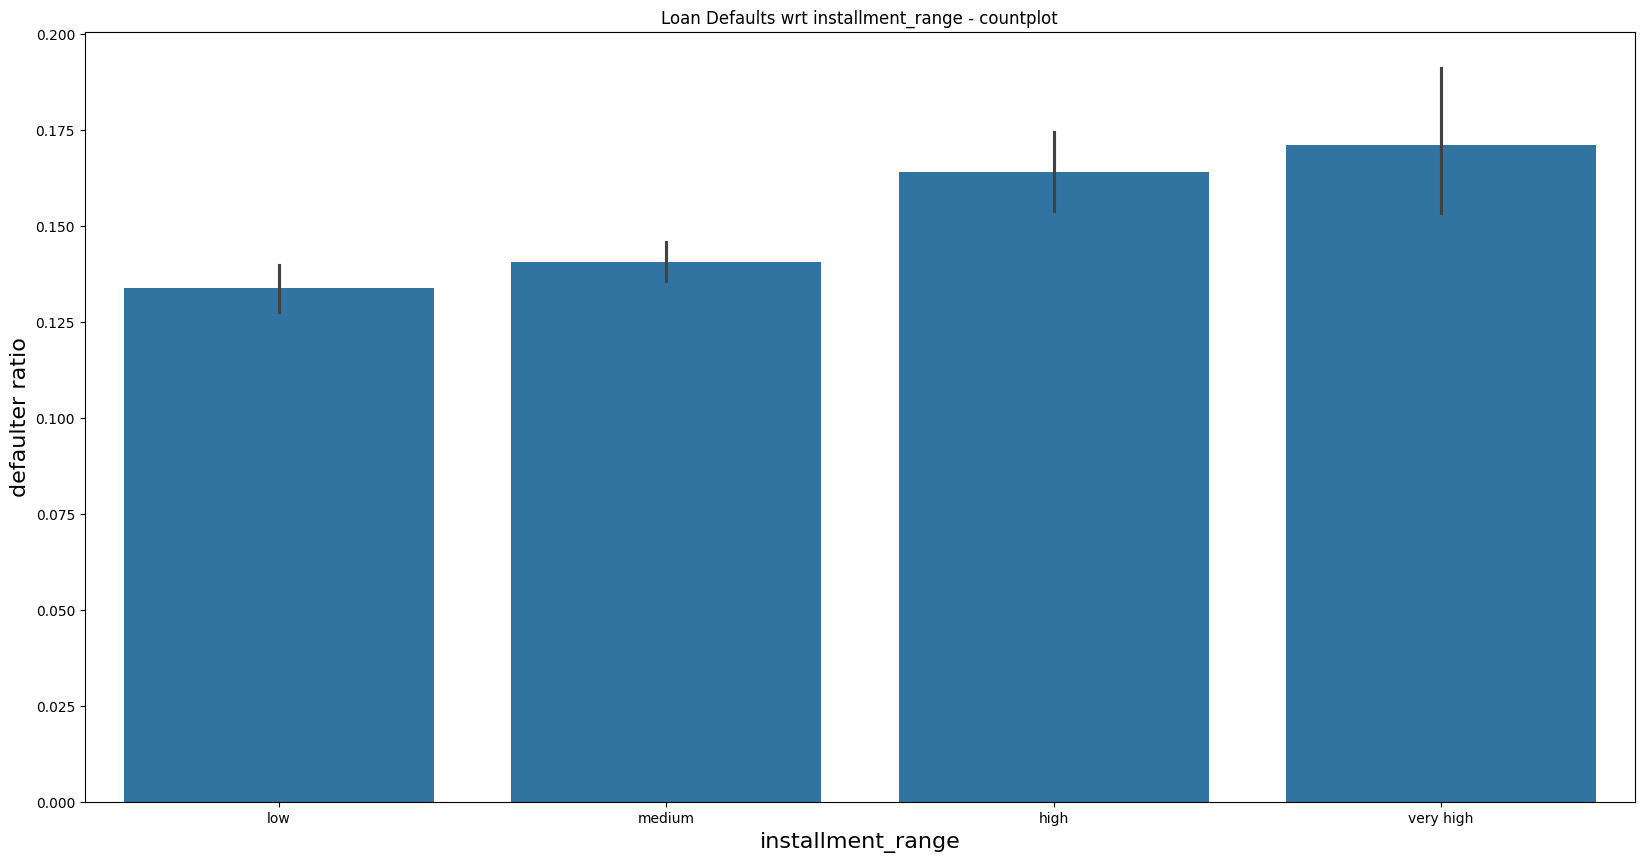

In [233]:
# check for defaulters wrt installment range in the data
plotUnivariateBarSegmentedByDefaulter("installment_range")

From above plot for ‘installment’ we can infer that the defaulters rate is increasing as with installment values, hence rate will depend on dti_range feature.

Therefore, following are the important feature we deduced from above Univariate analysis:

<ul>
<li>term</li>
<li>grade</li>
<li>purpose</li>
<li>pub_rec</li>
<li>pub_rec_bankruptcies</li>
<li>revol_util</li>
<li>funded_amnt_inv</li>
<li>int_rate</li>
<li>annual_inc</li>
<li>dti</li>
<li>installment</li>
</ul>

# 7. Bivariate Analysis

In [264]:
# function to plot scatter plot for two features
def plotScatter(x, y):
    plt.figure(figsize=(16,6))
    sns.scatterplot(x=x, y=y, hue="loan_status", data=loan)
    plt.title("Scatter plot between "+x+" and "+y)
    plt.xlabel(x, fontsize=16)
    plt.ylabel(y, fontsize=16)
    plt.show()
    
def plotBivariateBar(x, hue):
    plt.figure(figsize=(16,6))
    sns.barplot(x=x, y='is_defaulter', hue=hue, data=loan)
    plt.title("Loan Default ratio wrt "+x+" for "+hue+" in the data using countplot")
    plt.xlabel(x, fontsize=16)
    plt.ylabel("defaulter ratio", fontsize=16)
    plt.show()

def plotBivariateHistogram(x, hue):
    plt.figure(figsize=(16,6))
    sns.histplot(x=x, hue=hue, data=loan, multiple='stack', kde=True)
    plt.title("Loan Default ratio wrt "+x+" for "+hue+" in the data using Histogram")
    plt.xlabel(x, fontsize=16)
    plt.ylabel("Frequency", fontsize=16)
    plt.show()


### 7.1 Categorial Data

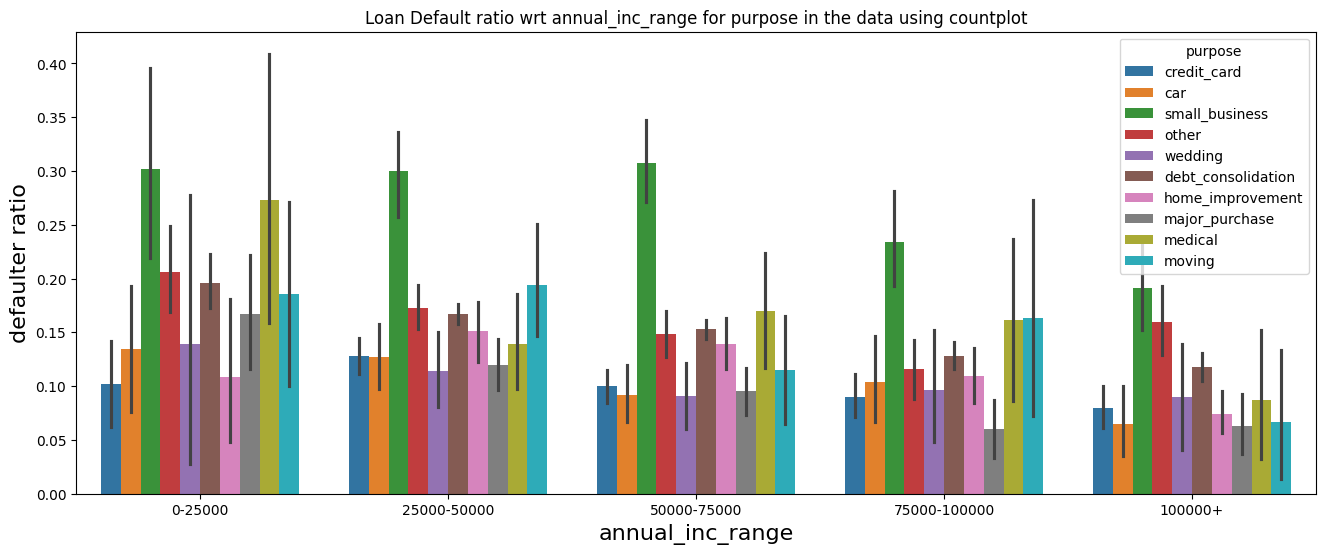

In [235]:
# check for defaulters wrt annual_inc and purpose in the data using countplot
plotBivariateBar("annual_inc_range", "purpose")

From above plot, we can infer it doesn’t shows any correlation

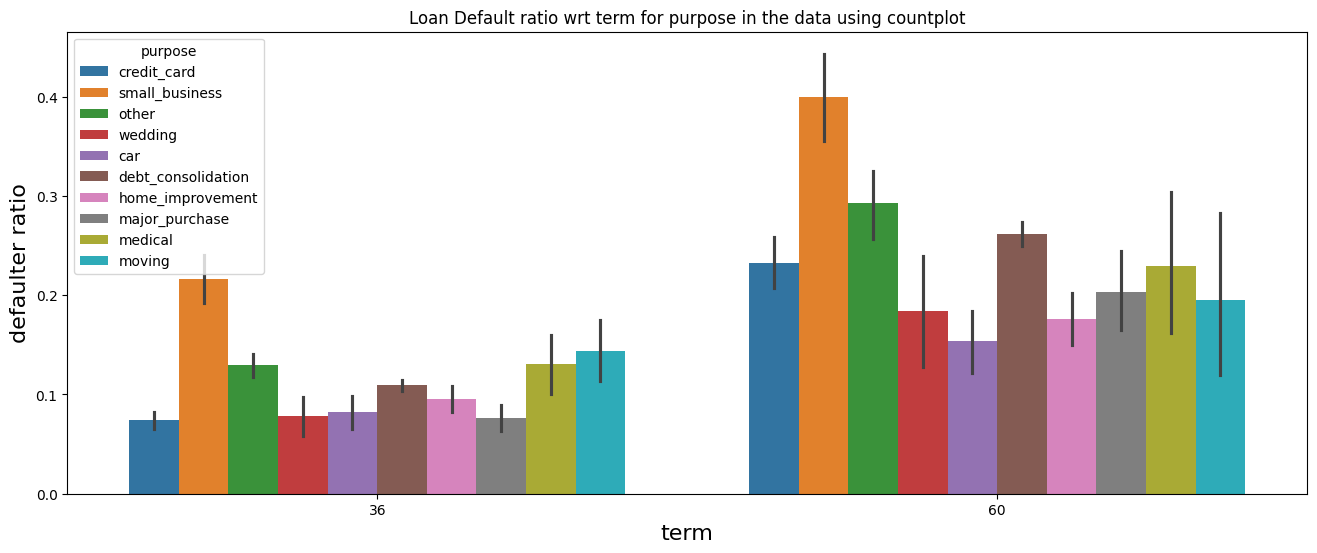

In [236]:
# check for defaulters wrt term and purpose in the data 
plotBivariateBar("term", "purpose")

As we can see , default ratio increases for every purpose wrt term

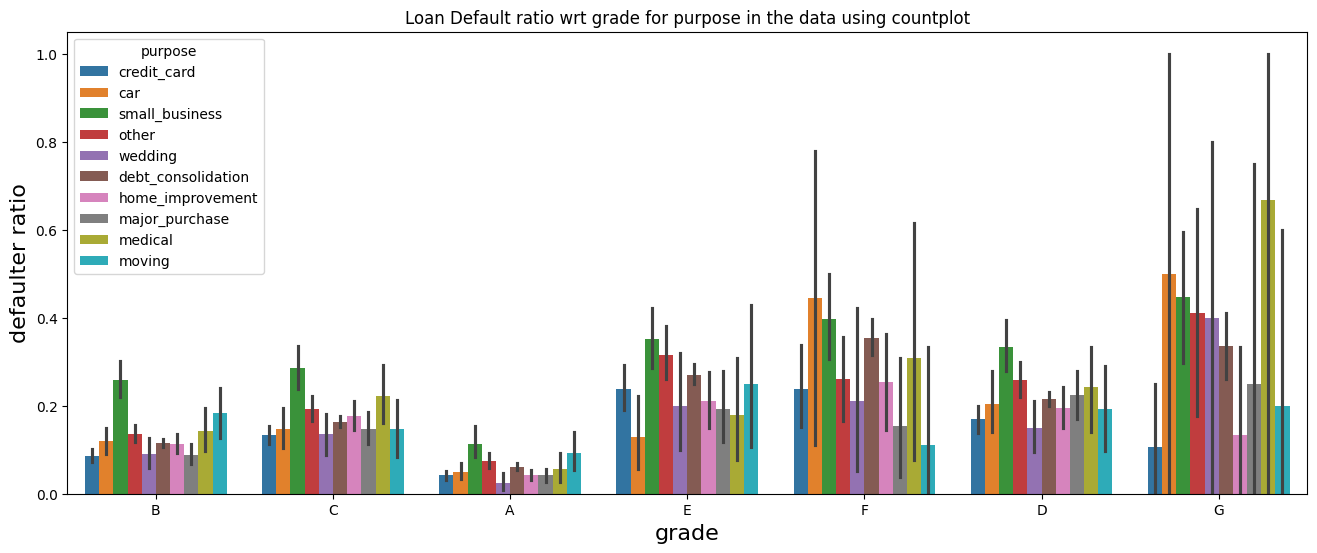

In [237]:
# check for defaulters wrt grade and purpose in the data 
plotBivariateBar("grade", "purpose")

As we can see default ratio increases for every purpose wrt grade

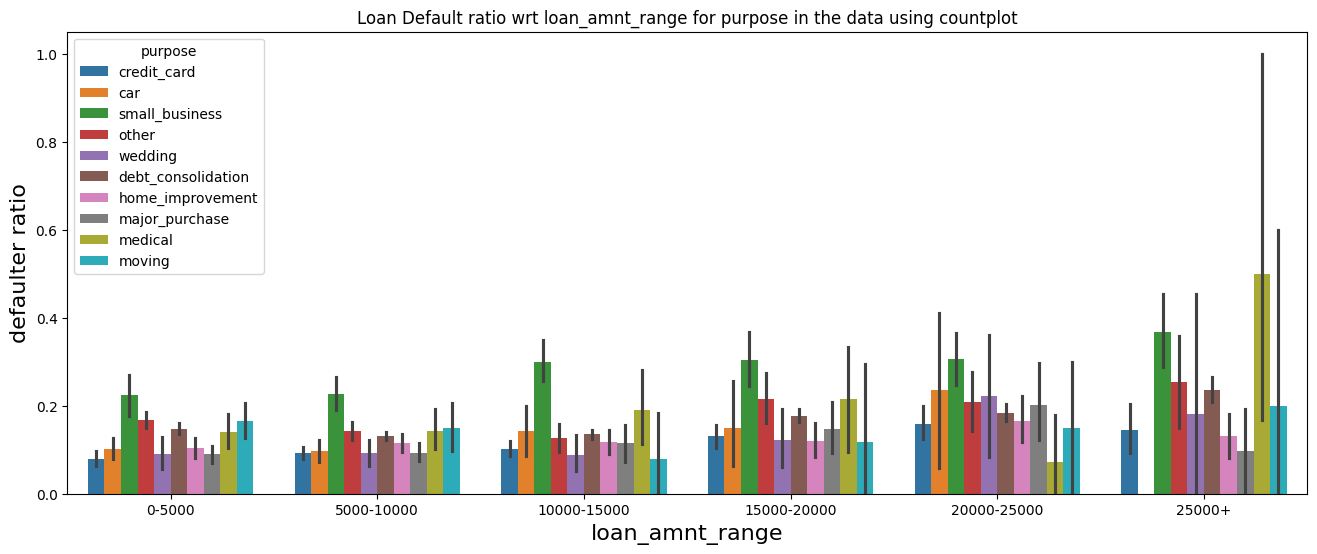

In [238]:
# check for defaulters wrt loan_amnt_range and purpose in the data
plotBivariateBar("loan_amnt_range", "purpose")

As we can see default ratio increases for every purpose wrt loan_amnt_range

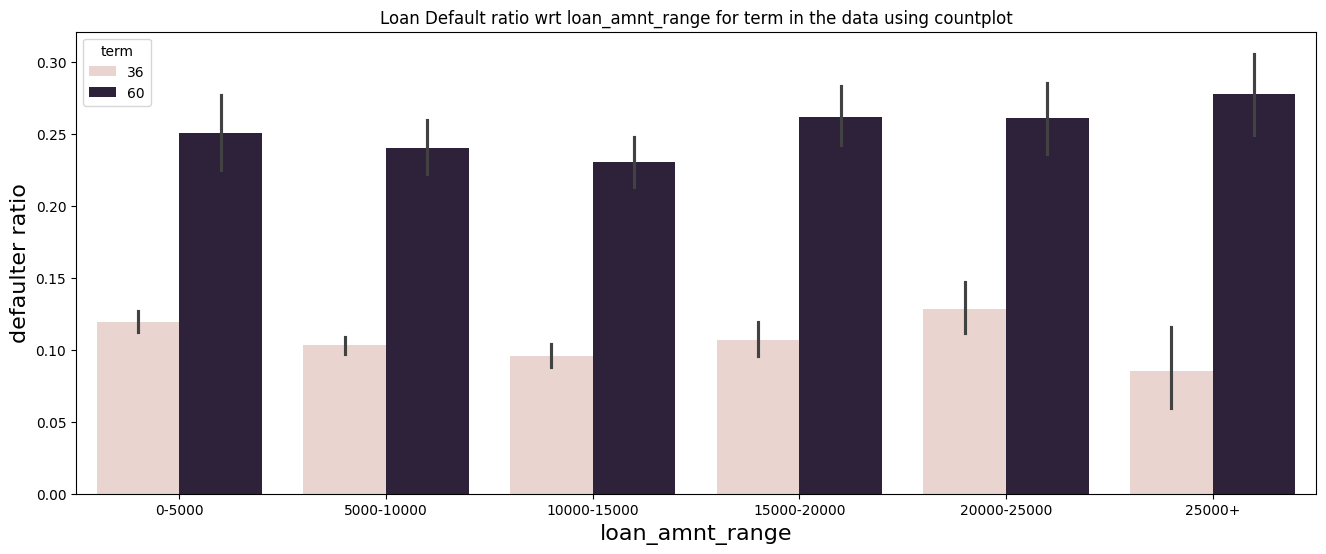

In [239]:
# check for defaulters wrt loan_amnt_range and term in the data
plotBivariateBar("loan_amnt_range", "term")

As we can see as loan amount range increase then default ratio also increases for every term wrt loan_amnt_range

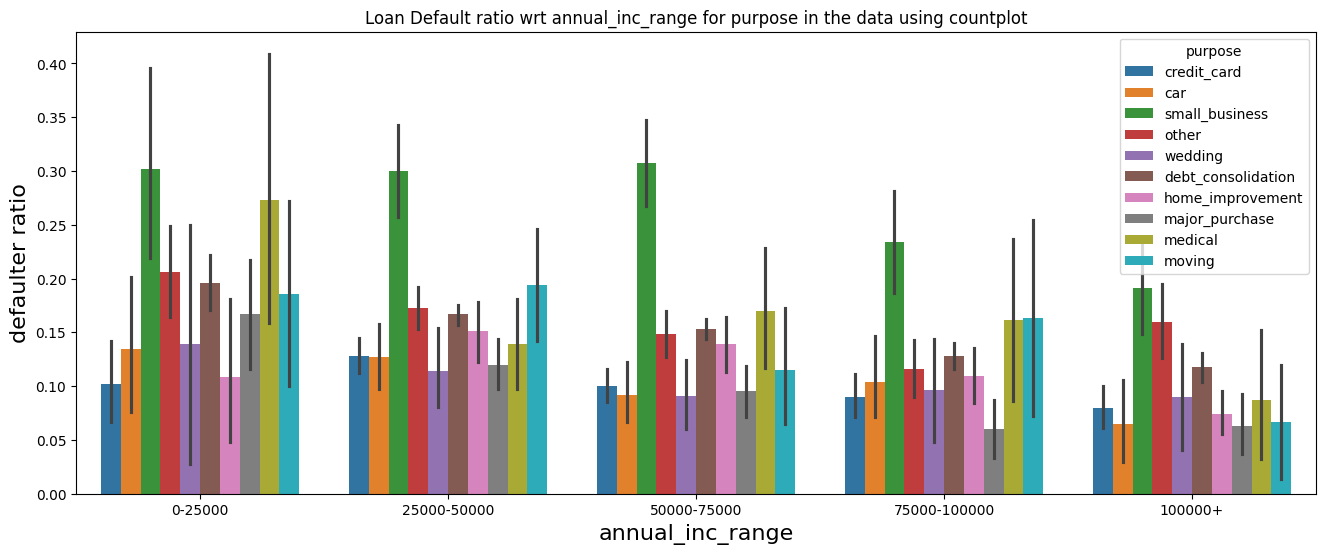

In [240]:
# check for defaulters wrt annual_inc_range and purpose in the data
plotBivariateBar("annual_inc_range", "purpose")

As we can see default ratio increases for every purpose wrt annual_inc_range

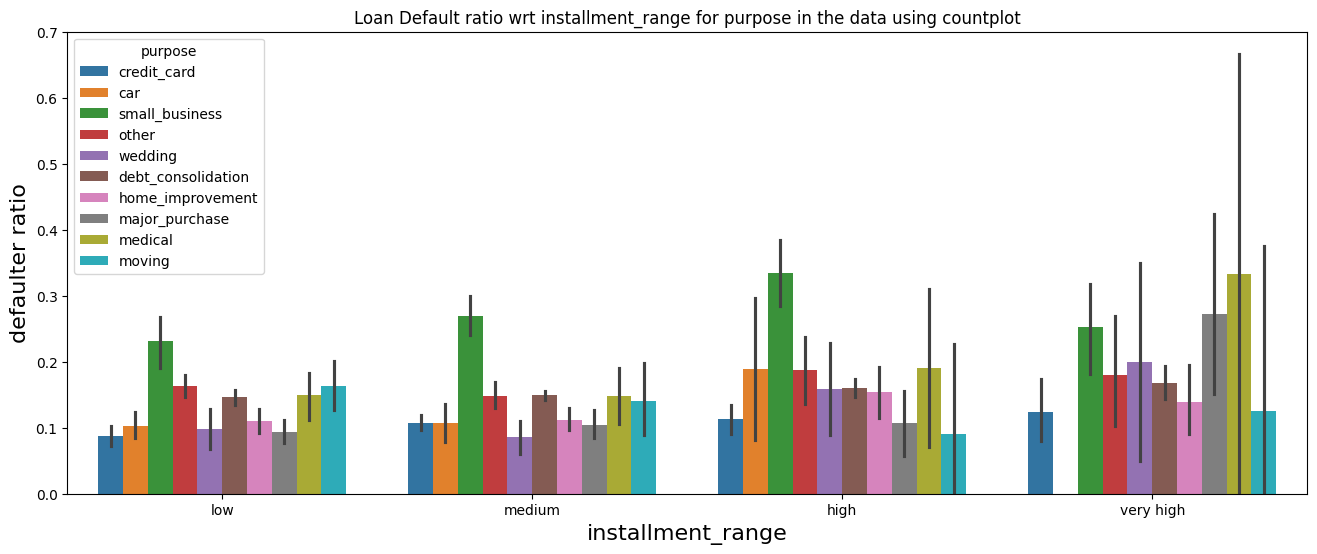

In [241]:
# check for defaulters wrt installment and purpose in the data
plotBivariateBar("installment_range", "purpose")

As we can see  default ratio increases for every purpose wrt installment except for small_business

### 7.2 Continuous Data

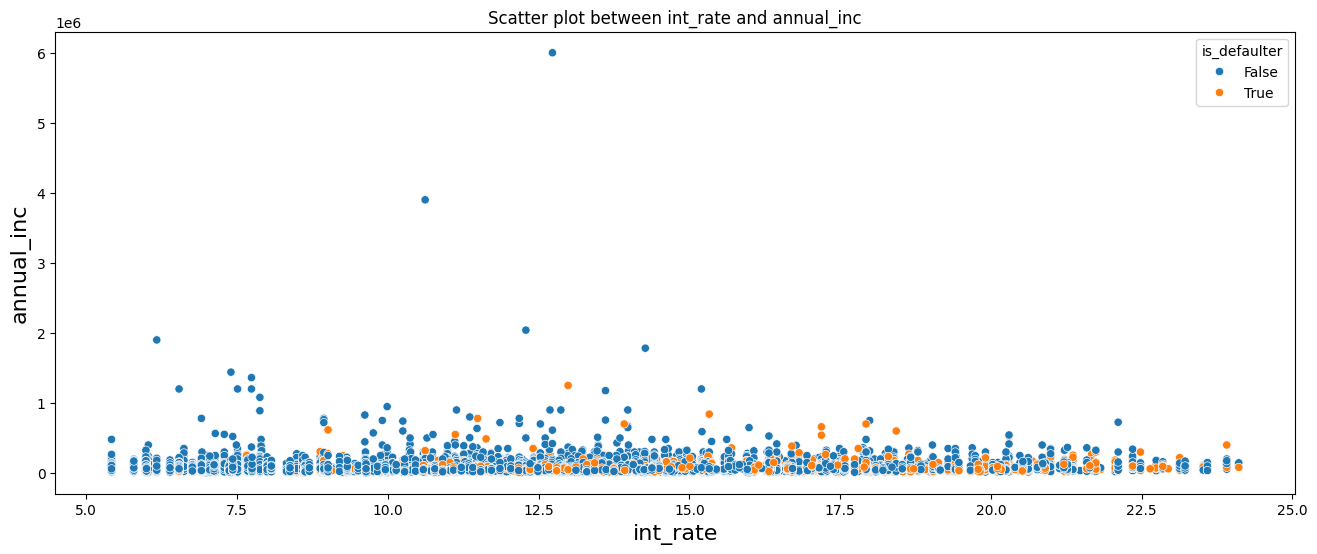

In [242]:
# check for defaulters wrt int_rate and annual_inc in the data
plotScatter("int_rate", "annual_inc")

As we can see straight lines on the plot, there is no relation between above mentioned features

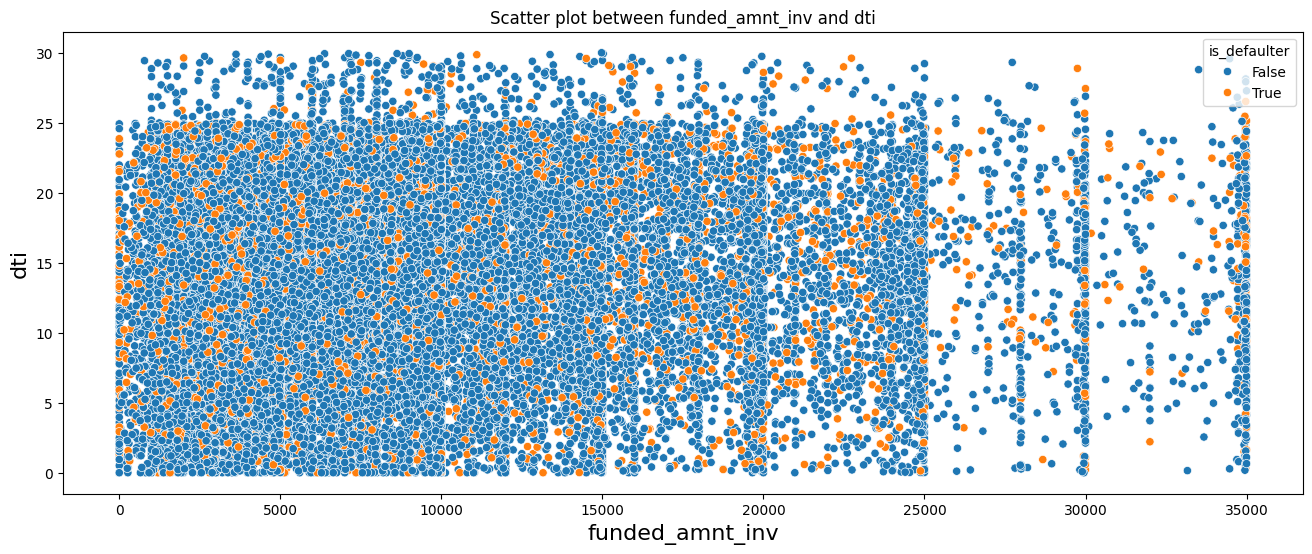

In [243]:
# plot scatter for funded_amnt_inv with dti
plotScatter("funded_amnt_inv", "dti")

As we can see straight lines on the plot, there is no relation between above mentioned features

In [259]:
loan["annual_inc"].value_counts()

annual_inc
60000.00     1406
50000.00      985
40000.00      803
45000.00      766
65000.00      754
             ... 
120120.00       1
58852.56        1
90696.00        1
74646.00        1
27376.00        1
Name: count, Length: 4895, dtype: int64

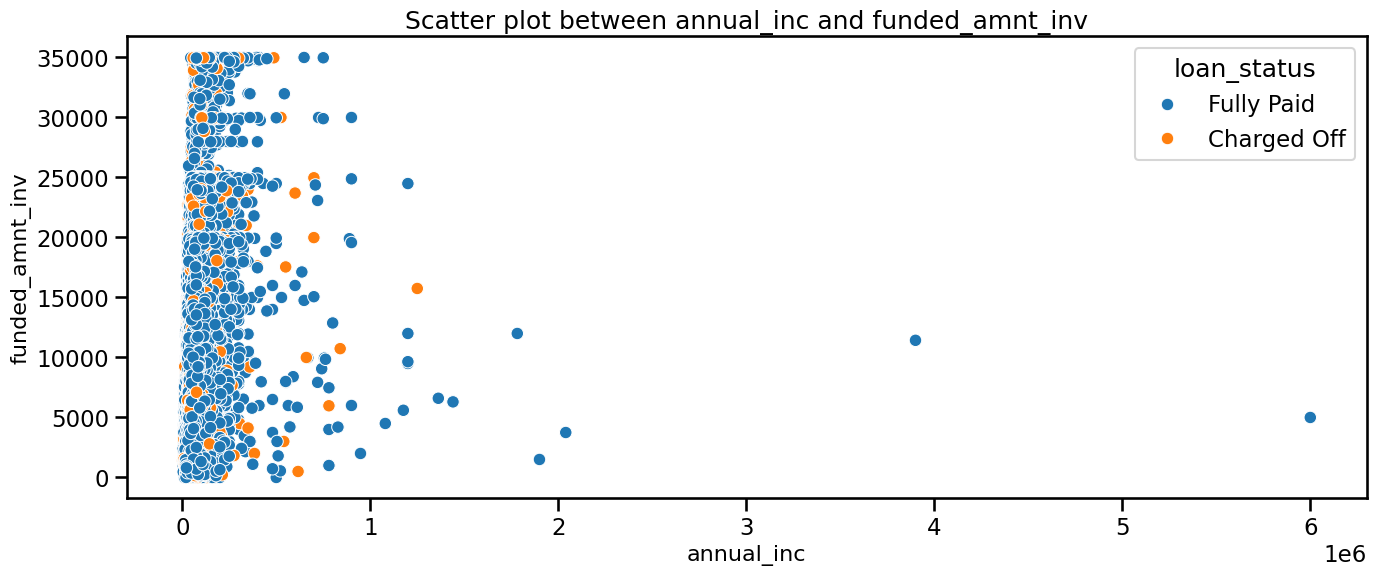

In [265]:
# plot scatter for funded_amnt_inv with annual_inc
plotScatter("annual_inc", "funded_amnt_inv")

As we can see slope pattern on the plot, there is positive relation between above mentioned features

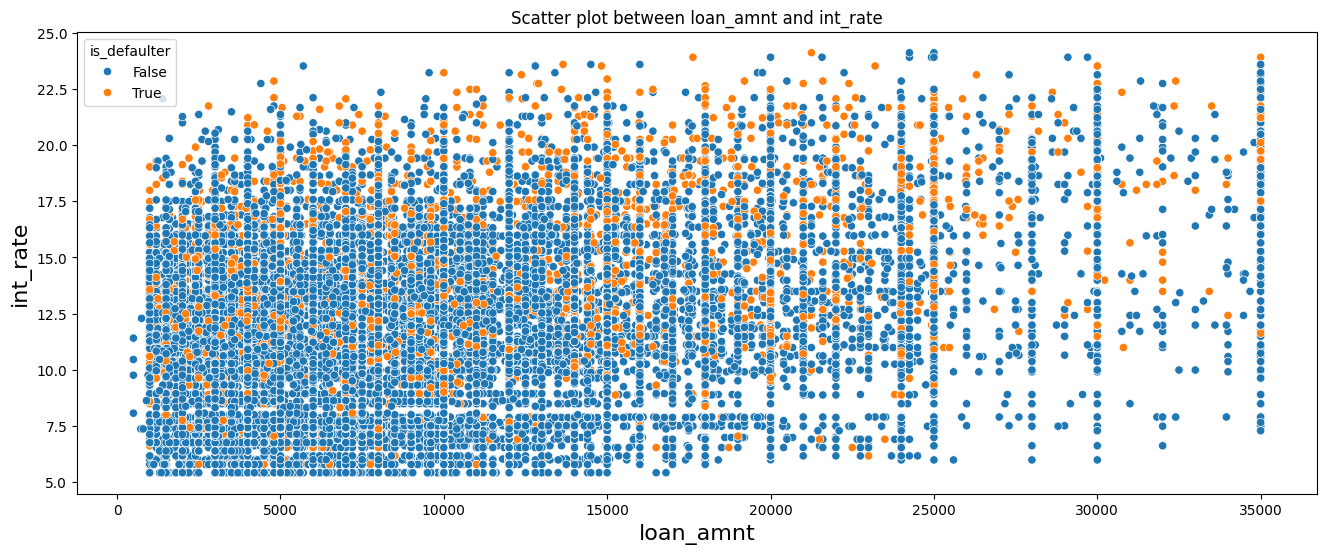

In [245]:
# plot scatter for loan_amnt with int_rate
plotScatter("loan_amnt", "int_rate")

As we can see straight line patterns on the plot, there is no relation between above mentioned features

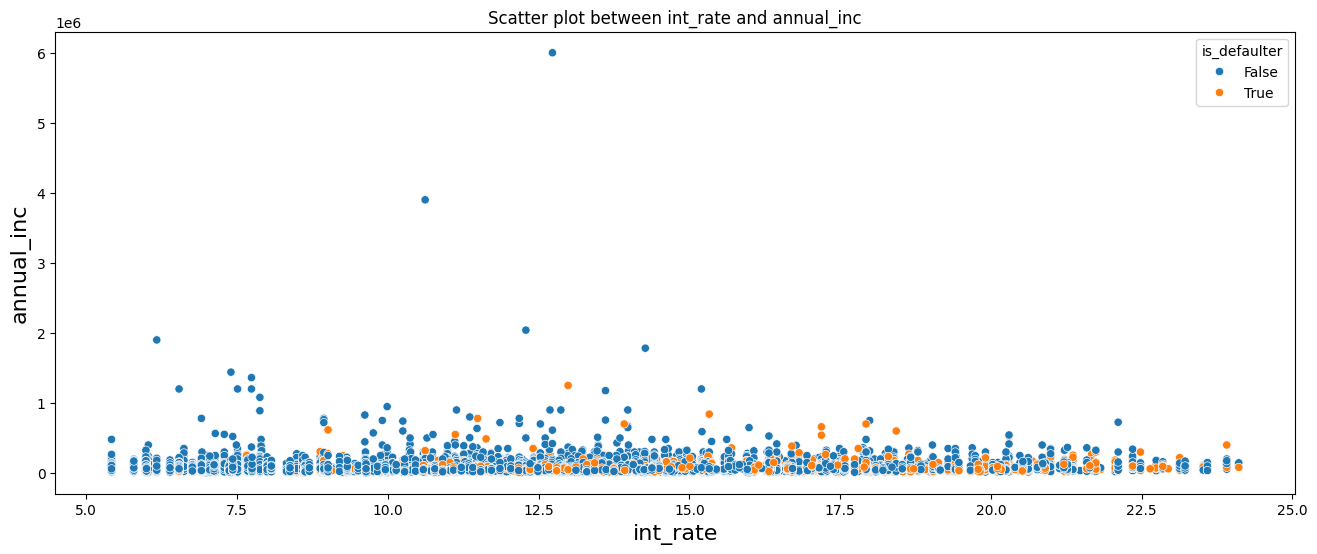

In [246]:
# plot scatter for int_rate with annual_inc
plotScatter("int_rate", "annual_inc")

As we can see negative correlation pattern with reduced density on the plot, there is some relation between above mentioned features

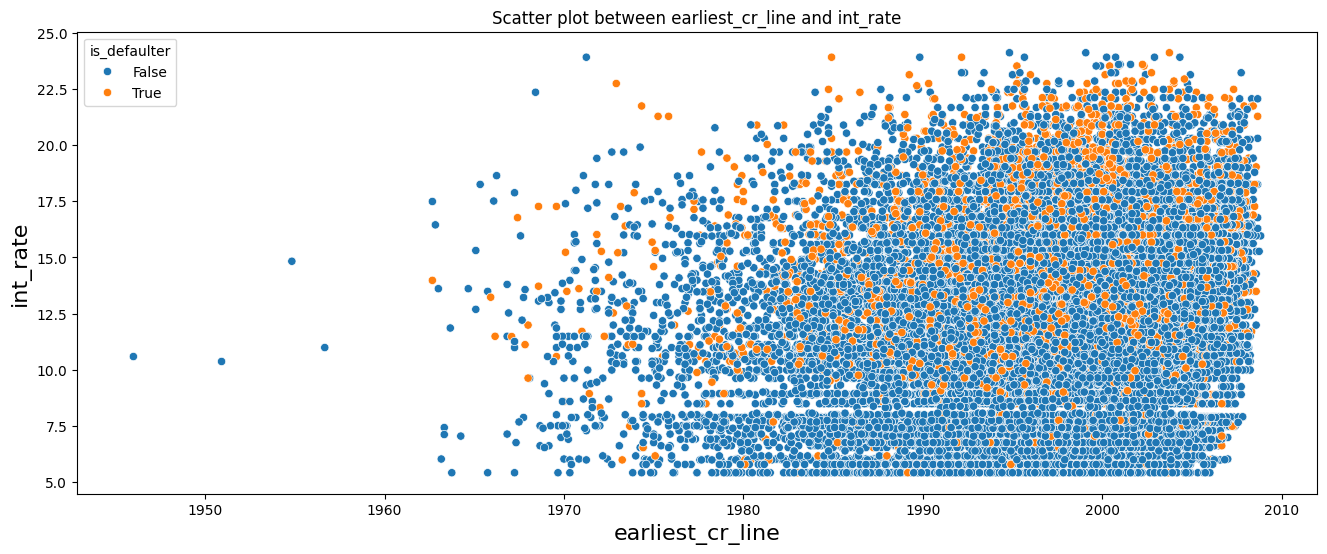

In [247]:
# plot scatter for earliest_cr_line with int_rate
plotScatter("earliest_cr_line", "int_rate")

As we can see positive correlation pattern with increasing density on the plot, there is co-relation between above mentioned features

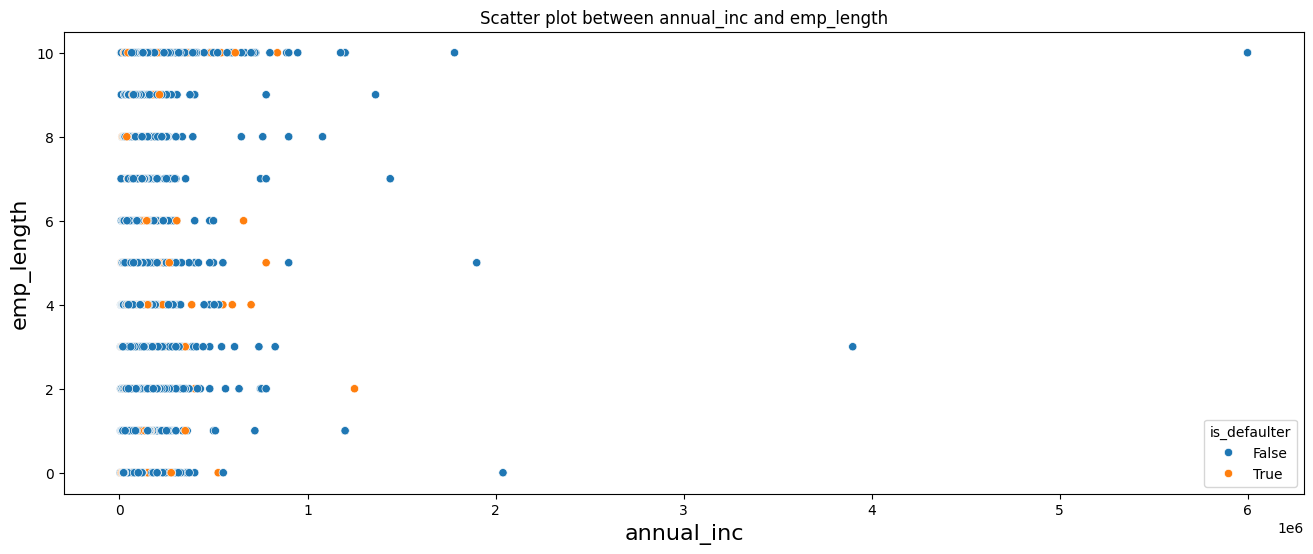

In [248]:
# plot scatter for annual_inc with emp_length
plotScatter("annual_inc", "emp_length")

As we can see straight line patterns on the plot, there is no relation between above mentioned features

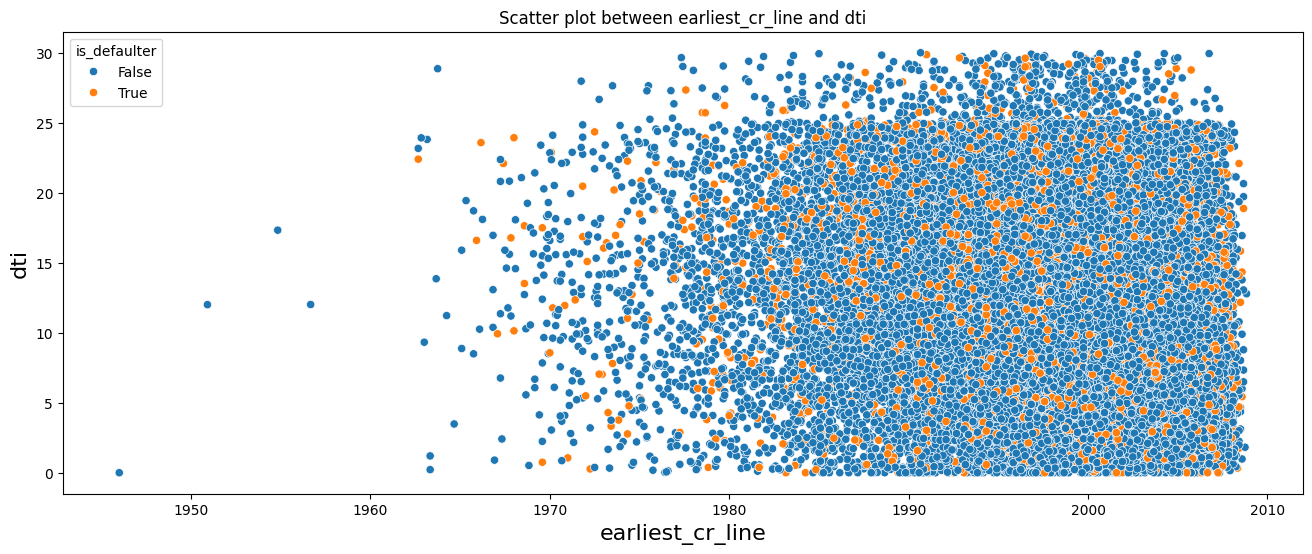

In [249]:
# plot scatter for earliest_cr_line with dti
plotScatter("earliest_cr_line", "dti")

Plotting for two different features with respect to loan default ratio on y-axis with Box Plots.

### 7.3 Categorial vs Continuous Data Types

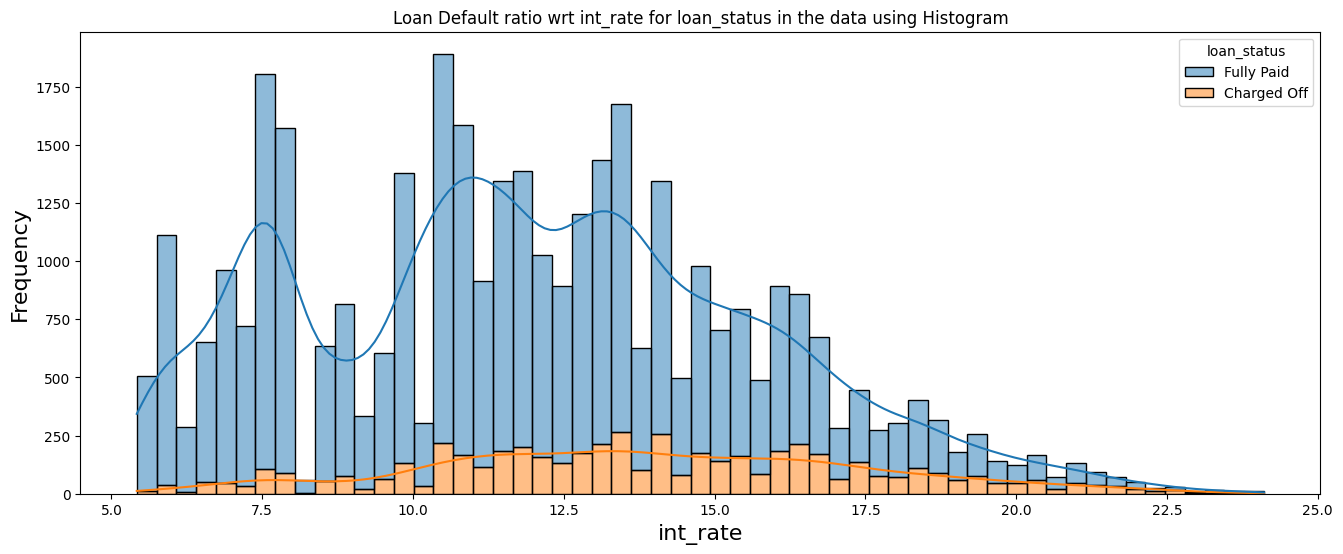

In [250]:
plotBivariateHistogram("int_rate", "loan_status")

In [251]:
# function to plot boxplot for comparing two features
def plotBox(x, y, hue="loan_status"):
    plt.figure(figsize=(16,6))
    sns.boxplot(x=x, y=y, data=loan, hue=hue, order=sorted(loan[x].unique()))
    plt.title("Box plot between "+x+" and "+y+" for each "+hue)
    plt.xlabel(x, fontsize=16)
    plt.ylabel(y, fontsize=16)
    plt.show()
    plt.figure(figsize=(16,8))
    plt.show()

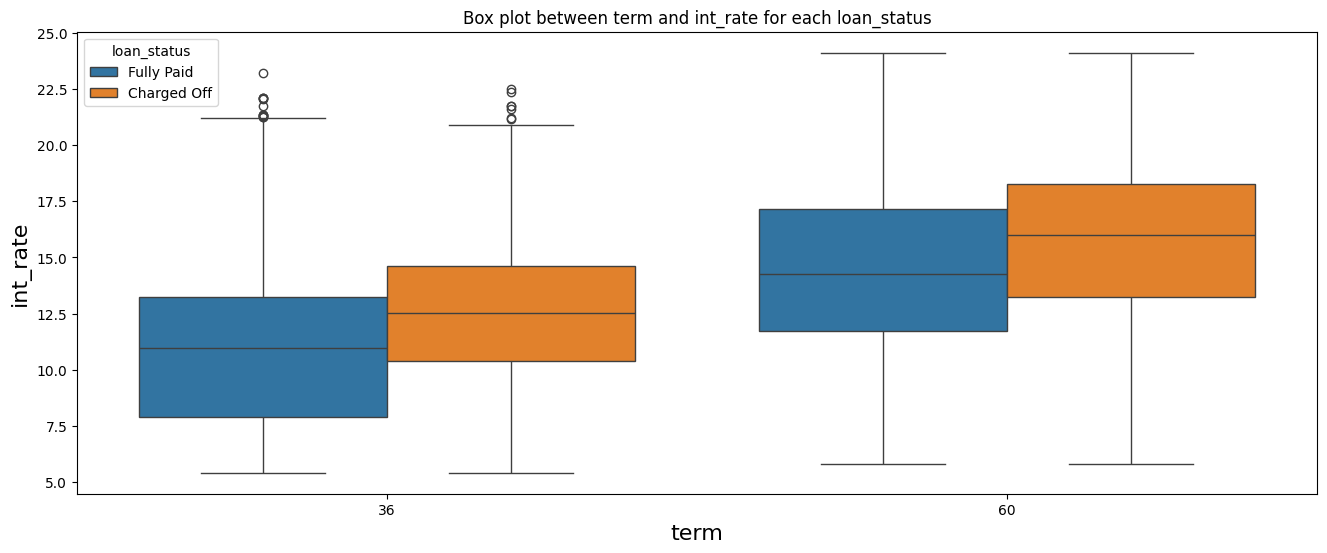

<Figure size 1600x800 with 0 Axes>

In [252]:
# plot box for term vs int_rate for each loan_status
plotBox("term", "int_rate")

int_rate increases with term on loan and the chances of default also increases

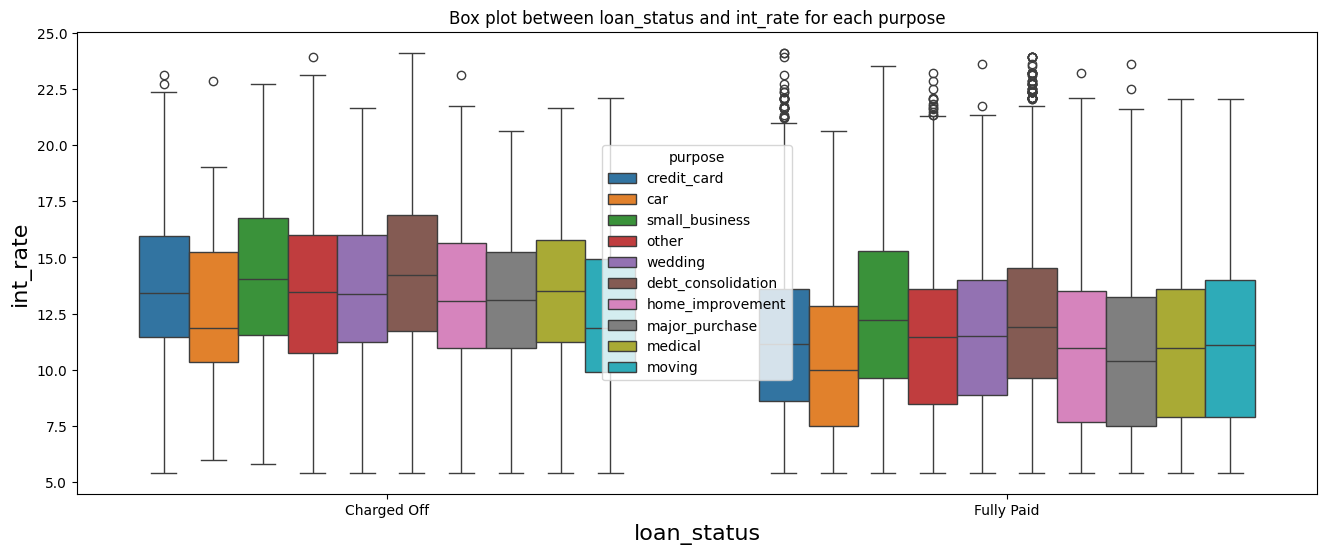

<Figure size 1600x800 with 0 Axes>

In [253]:
# plot box for loan_status vs int_rate for each purpose
plotBox("loan_status", "int_rate", hue="purpose")

int_rate is quite high where the loan is defaulted for every purpose value

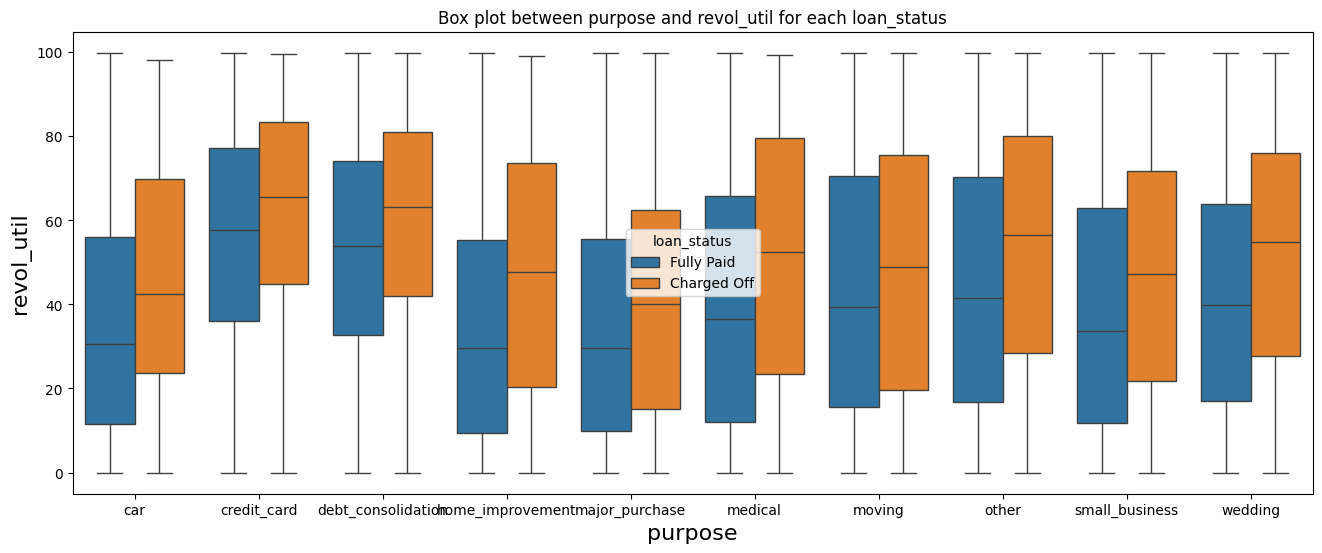

<Figure size 1600x800 with 0 Axes>

In [254]:
# plot box for purpose vs revo_util for each status
plotBox("purpose", "revol_util")

revol_util is more for every purpose value where the loan is defaulted and quite high for credit_card

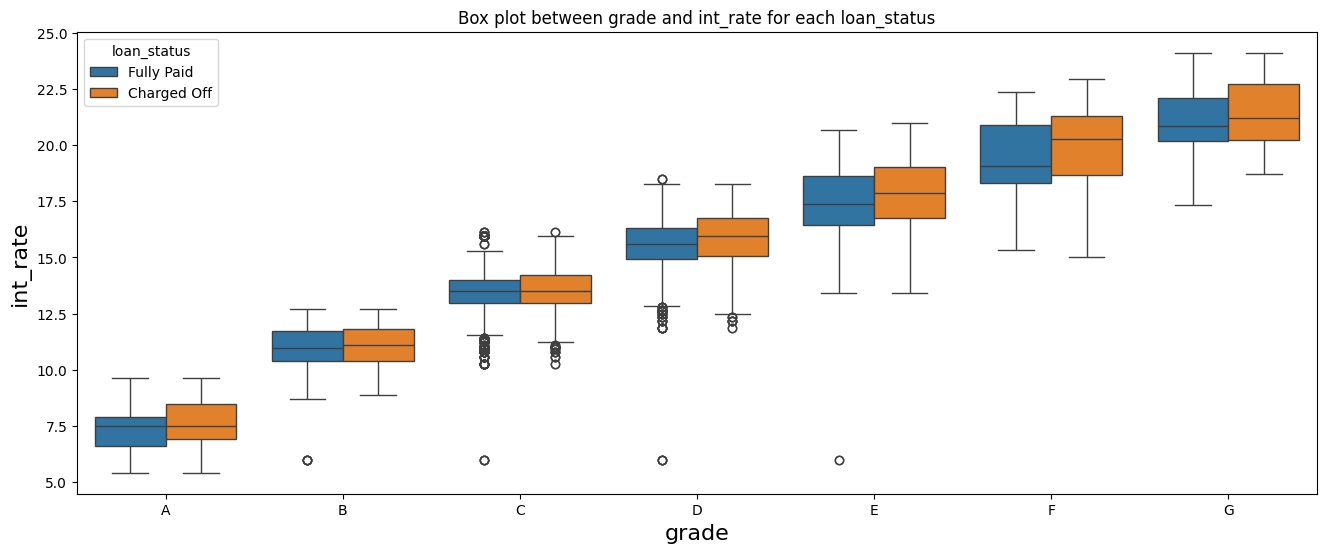

<Figure size 1600x800 with 0 Axes>

In [255]:
# plot box for grade vs int_rate for each loan_status
plotBox("grade", "int_rate", "loan_status")

int_rate is increasing with every grade and also the defaulters for every grade are having their median near the non-defaulter 75% quantile of int_rate

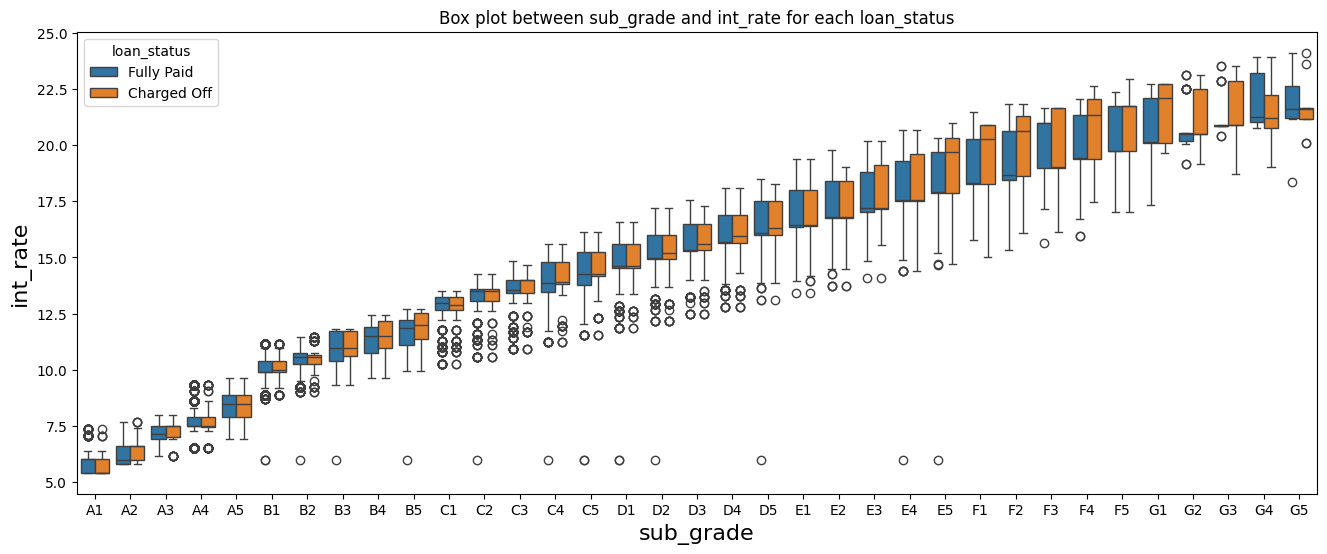

<Figure size 1600x800 with 0 Axes>

In [256]:
# plot box for sub_grade vs int_rate for each loan_status
plotBox("sub_grade", "int_rate", "loan_status")

int_rate is increasing with every sub_grade thus increase likelihood of defaulters.

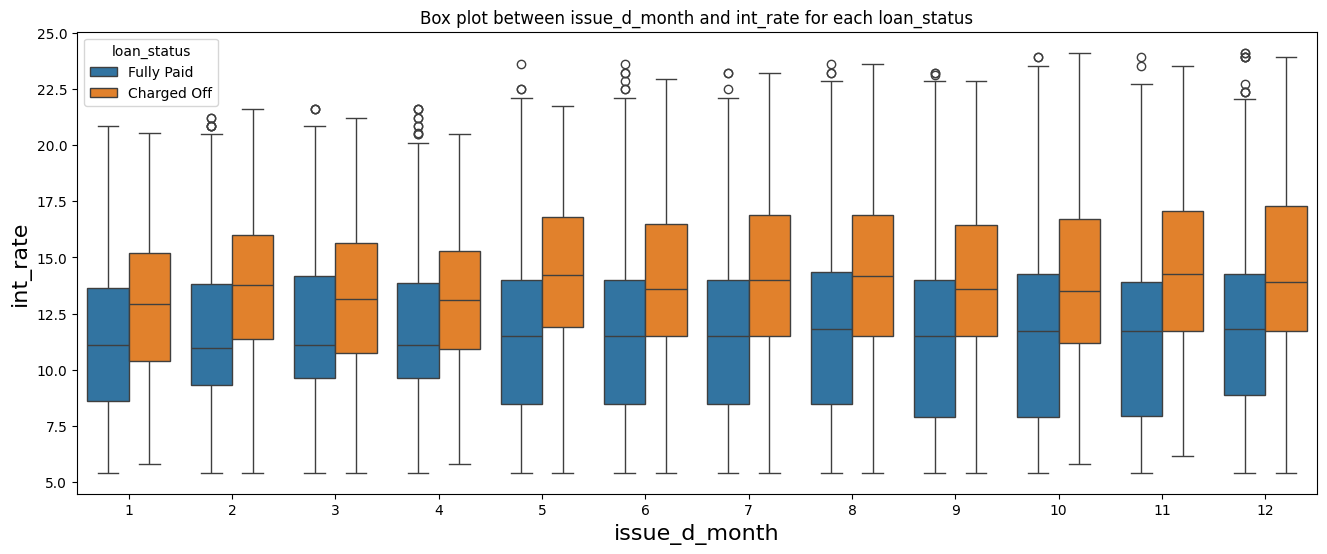

<Figure size 1600x800 with 0 Axes>

In [257]:
# plot box for issue_d vs int_rate for each loan_status
plotBox("issue_d_month", "int_rate")

int_rate for defaulter is increasing with every month where the defaulters for every month are having their median near the non-defaulter’s 75% quantile of int_rate, but is almost constant for each month, hence not useful

Therefore, following are the important feature we deduced from above Bivariate analysis:
<ul>
<li>term
<li>grade
<li>purpose
<li>pub_rec
<li>revol_util
<li>funded_amnt_inv
<li>int_rate
<li>annual_inc
<li>installment
</ul>

# 8 Multivariate Analysis (Correlation)

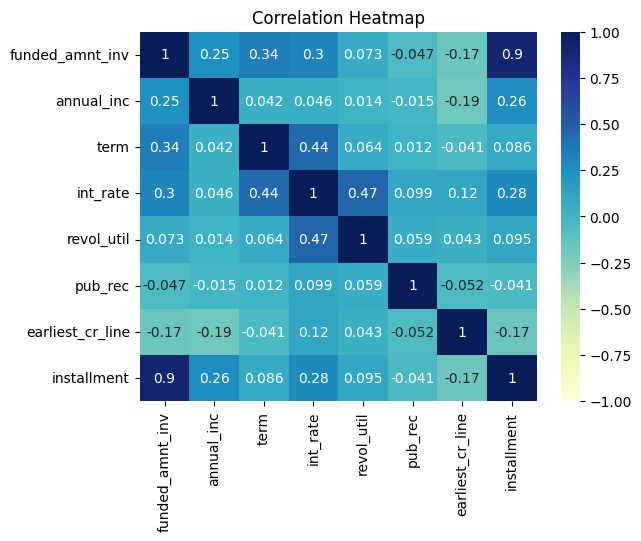

In [258]:
# plot heat map to see correlation between features
continuous_f = ["funded_amnt_inv", "annual_inc", "term", "int_rate", "revol_util", "pub_rec", "earliest_cr_line", "installment"]
loan_corr = loan[continuous_f].corr()
sns.heatmap(loan_corr,vmin=-1.0,vmax=1.0,annot=True, cmap="YlGnBu")
plt.title("Correlation Heatmap")
plt.show()

Hence, important related feature from above Multivariate analysis are:

<ul>
<li>term
<li>grade
<li>purpose
<li>revol_util
<li>int_rate
<li>installment
<li>annual_inc
<li>funded_amnt_inv
</ul>

The best driving features for the Loan default analysis are: 
<ul>
<li>term
<li>grade
<li>purpose
<li>revol_util
<li>int_rate
<li>installment
<li>annual_inc
<li>funded_amnt_inv
<li>pub_rec
<li>pub_rec_bankruptcies
</ul>